In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('loan.csv')
df.head(1)

C:\Users\davadhani\AppData\Local\Temp\ipykernel_30532\1966195624.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

## Data Cleaning
Upon manual inspection of the dataset, there seem to be a lot of columns with null values. Let us check and see if there are columns with only null values and remove them

In [4]:
empty_columns = []

for x in df.columns:
    if df[x].isna().all():
        empty_columns.append(x)

print(len(empty_columns))

54


In [5]:
df.drop(empty_columns, axis=1, inplace=True)

Dropped 54 columns that had only null values

Let us also have a look at a few columns that have only single values and are not going to contribute to our data analyses. It is important that we remove such columns.

In [6]:
df['tax_liens'].value_counts()

0.0    39678
Name: tax_liens, dtype: int64

In [7]:
df['delinq_amnt'].value_counts()

0    39717
Name: delinq_amnt, dtype: int64

In [8]:
df['chargeoff_within_12_mths'].value_counts()

0.0    39661
Name: chargeoff_within_12_mths, dtype: int64

In [9]:
df['acc_now_delinq'].value_counts()

0    39717
Name: acc_now_delinq, dtype: int64

In [10]:
df['application_type'].value_counts()

INDIVIDUAL    39717
Name: application_type, dtype: int64

In [11]:
df['policy_code'].value_counts()

1    39717
Name: policy_code, dtype: int64

In [12]:
df['collections_12_mths_ex_med'].value_counts()

0.0    39661
Name: collections_12_mths_ex_med, dtype: int64

In [13]:
df['initial_list_status'].value_counts()

f    39717
Name: initial_list_status, dtype: int64

In [14]:
invalid_columns = ['initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']

In [15]:
df.drop(invalid_columns, axis=1, inplace=True)

We removed columns that have only single values all across the dataset.

Let us check if the data set has any duplicate rows.

In [16]:
len(df['id'].unique())

39717

In [17]:
len(df)

39717

The id is unique for all rows and this dataset has no duplicated column values.

Upon manual inspection, we can see that 2 variables `int_rate` and `revol_util` that are expressed in percentage. Let us remove the % sign and convert the type to float.

In [18]:
def cleanPercentage(x):
    x = str(x)
    x = x.replace('%', '')
    return float(x)

df['int_rate'] = df['int_rate'].apply(lambda x: cleanPercentage(x))
df['revol_util'] = df['revol_util'].apply(lambda x: cleanPercentage(x))

In [19]:
df['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

Since we are only trying to look at customers who have defaulted, we might not need data related to the customers who are currently paying off their loans. Let's remove them.

In [20]:
df = df[df['loan_status']!='Current']

In [21]:
df.shape

(38577, 49)

That leaves us with a fair 35000 columns for analysis.

## Outlier Analysis

In [22]:
df.shape

(38577, 49)

There are 49 remaining columns in this dataframe now. The most important variables here would be `loan_amnt` and `annual_inc` which are driving factors. Let us analyse these columns and remove any outliers so our future analysis is smooth.

<Axes: ylabel='loan_amnt'>

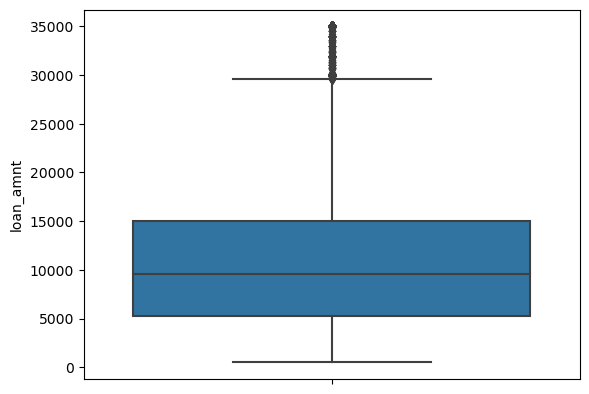

In [23]:
sns.boxplot(data=df, y='loan_amnt')

In [24]:
df = df[df['loan_amnt'] < 30000]

The upper fence for the box plot is around 30000, let us remove values that are above 30000.
Let's now look at `annual_inc`.

<Axes: ylabel='annual_inc'>

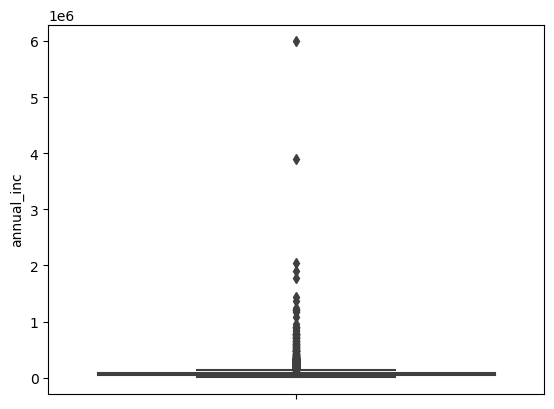

In [25]:
sns.boxplot(data=df, y='annual_inc')

In [26]:
df['annual_inc'].describe()

count    3.750500e+04
mean     6.714205e+04
std      6.293799e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.720000e+04
75%      8.000000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [27]:
np.quantile(df['annual_inc'], 0.95)

136156.79999999964

In [28]:
df = df[df['annual_inc'] < 137000]

We removed all values that are above the 95th quartile for `annual_inc` as people with such high annual incomes do not usually look for loans around 30000$.

In [29]:
len(df[df['loan_status']=='Fully Paid'])

30453

In [30]:
len(df[df['loan_status']=='Charged Off'])

5184

There is an imbalance in the dataset as data related to customers who have defaulted is less than customers who have paid the amount.

## Univariate / Segmented Univariate analysis

There are a few analysis templates that we will follow for categorical and numeric variables. Let us first write some custom functions that will do the calculations for us before we proceed with univariate analysis.

1) `Categorical variables`:- For categoric variables we will use a seaborn count plot that seperately shows number of defaulted and non defaulted customers for each of the categories of the variable. This is a very useful plot, but is NOT sufficient because there is an imbalance in the dataset. The number of defaulted customers are significantly less than the customers that have not defaulted, hence we would also need to analyse the proportion of people who defaulted for each category of the categorical variable. Let us first write the method.

In [31]:
def gatherProportions(frame, values, column_name):
    data = pd.DataFrame(columns=[column_name,'default_ratio','non_default_ratio'])
    for x in values:
        sub = frame[frame[column_name]==x]
        default_ratio = (len(sub[sub['loan_status']=='Charged Off'])/len(sub))*100
        non_default_ratio = 100.0 - default_ratio
        data.loc[len(data.index)] = [x, default_ratio, non_default_ratio]
    
    return data

In [32]:
def plotForCategoricalVariables(frame, column_name):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.countplot(data=frame, x=column_name, hue='loan_status', order=sorted(frame[column_name].unique()), ax=axes[0])
    axes[0].set_title('Count plot for ' + column_name + ' with respect to loan_status')
    
    proportions = gatherProportions(frame, sorted(frame[column_name].unique()), column_name)
    sns.barplot(data=proportions, x=column_name, y='default_ratio', order=sorted(frame[column_name].unique()), ax=axes[1])
    axes[1].set_title('Percentage of people that defaulted')
    plt.tight_layout()
    plt.show()

In [33]:
def plotForCategoricalVariablesYAxis(frame, column_name):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.countplot(data=frame, y=column_name, hue='loan_status', order=sorted(frame[column_name].unique()), ax=axes[0])
    axes[0].set_title('Count plot for ' + column_name + ' with respect to loan_status')
    
    proportions = gatherProportions(frame, sorted(frame[column_name].unique()), column_name)
    sns.barplot(data=proportions, y=column_name, x='default_ratio', order=sorted(frame[column_name].unique()), ax=axes[1])
    axes[1].set_title('Percentage of people that defaulted')
    plt.tight_layout()
    plt.show()

2) `Numeric variables`:- We will use segmented univariate box plots to analyse the distribution of the variable for each `loan_status`. We will also qdcut the numeric variable and analyse the percentage of people who defaulted for each cut.

In [34]:
def plotForNumericVariables(df, col1):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    sns.boxplot(data=df, x=col1, y='loan_status', ax=axes[0])
    
    df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
    paid_pivot = pd.pivot_table(data=df[df['loan_status']=='Fully Paid'], index=col1+'_bucket', values='id', aggfunc='count')
    default_pivot = pd.pivot_table(data=df[df['loan_status']=='Charged Off'], index=col1+'_bucket', values='id', aggfunc='count')
    proportion_df = default_pivot.divide(paid_pivot.add(default_pivot))
    sns.barplot(data=proportion_df, x=proportion_df.index, y='id', ax=axes[1])
    axes[1].set_title('Percentage of people that defaulted')
    axes[1].set_ylabel('Proportion of people defaulted')
    
    df.drop(col1+'_bucket', axis=1, inplace=True)
    plt.tight_layout()
    plt.show()

In [35]:
sns.set_style('darkgrid')

Let us begin the process of univariate analysis.

## Int_Rate

Interest rate determines the extra percentage principal amount that the customer would need to repay the bank after the term completes.

In [36]:
df['int_rate'].isna().sum()

0

<Axes: xlabel='int_rate'>

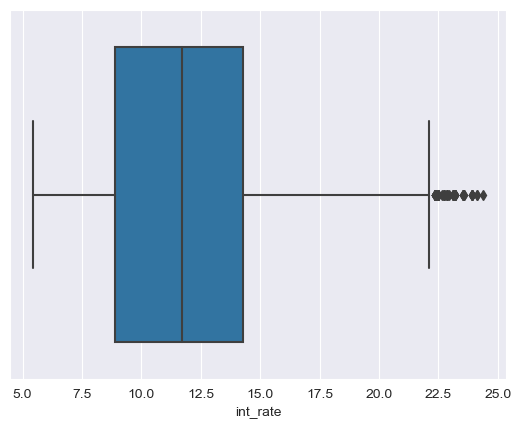

In [37]:
sns.boxplot(data=df, x='int_rate')

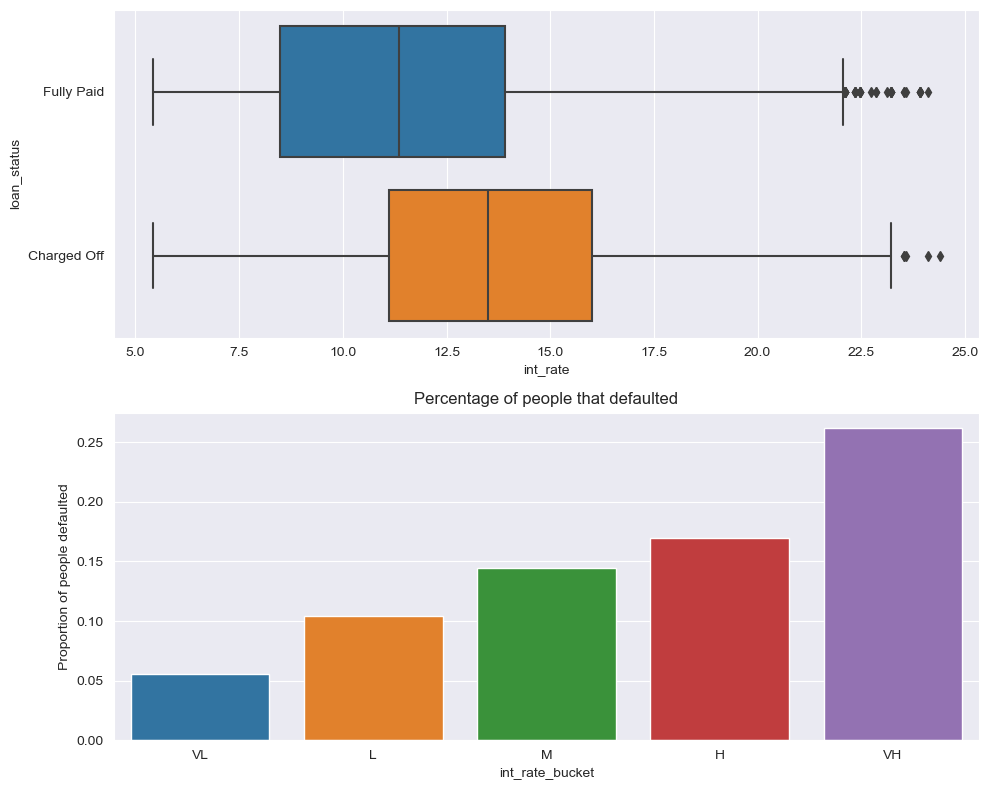

In [38]:
plotForNumericVariables(df, 'int_rate')

In [39]:
df[df['loan_status']=='Charged Off']['int_rate'].describe()

count    5184.000000
mean       13.618410
std         3.570913
min         5.420000
25%        11.120000
50%        13.490000
75%        16.020000
max        24.400000
Name: int_rate, dtype: float64

In [40]:
df[df['loan_status']=='Fully Paid']['int_rate'].describe()

count    30453.000000
mean        11.489891
std          3.524618
min          5.420000
25%          8.490000
50%         11.360000
75%         13.920000
max         24.110000
Name: int_rate, dtype: float64

There is a very clear indicator here. The box plot indicates that the median interest rate for customers who defaulted is significantly higher than customers who paid the loans. The 2nd plot, shows that as the interest rate increases from VL (Very Low) to (Very High), the percentage of people who defaulted keeps increase on every step. **Higher interest implies a higher chance that customer would default on the loans**.

## Loan_Amnt

In [41]:
df['loan_amnt'].isna().sum()

0

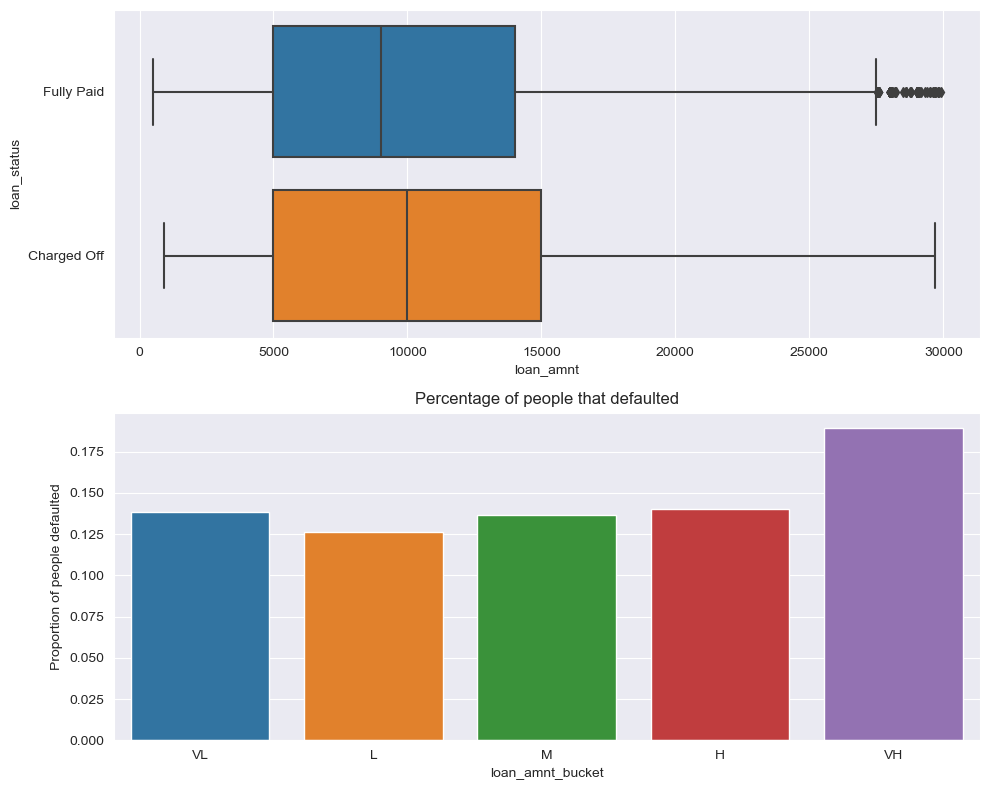

In [42]:
plotForNumericVariables(df, 'loan_amnt')

`loan_amnt` does not seem to be a strong indicator of default. We can see here that for loan_amnts low to high, the distribution is approximately uniform.

## funded_amnt

This variable indicates the total amount of loan committed by the bank to the loan. On manual inspection in most cases this is similar to loan_amnt as expected, hence there seems to be a high degree of correlation between this variable and loan_amnt.

In [43]:
df['loan_amnt'].corr(df['funded_amnt'])

0.9813592965157907

The same seems to be the case with `funded_amnt_inv` which is the total amount funded by investors of the bank on the loan and `total_payment` which is the final amount to be paid back, which are proportional to the loan amount obtained.

In [44]:
df['loan_amnt'].corr(df['funded_amnt_inv'])

0.9280607884238207

In [45]:
df['loan_amnt'].corr(df['total_pymnt'])

0.8757200498714749

We will hence not independently consider these for analysis and will instead use `loan_amnt`.

## Term

In [46]:
df['term'].isna().sum()

0

In [47]:
plt.subplots_adjust(bottom=0.4, top=0.6)

<Figure size 640x480 with 0 Axes>

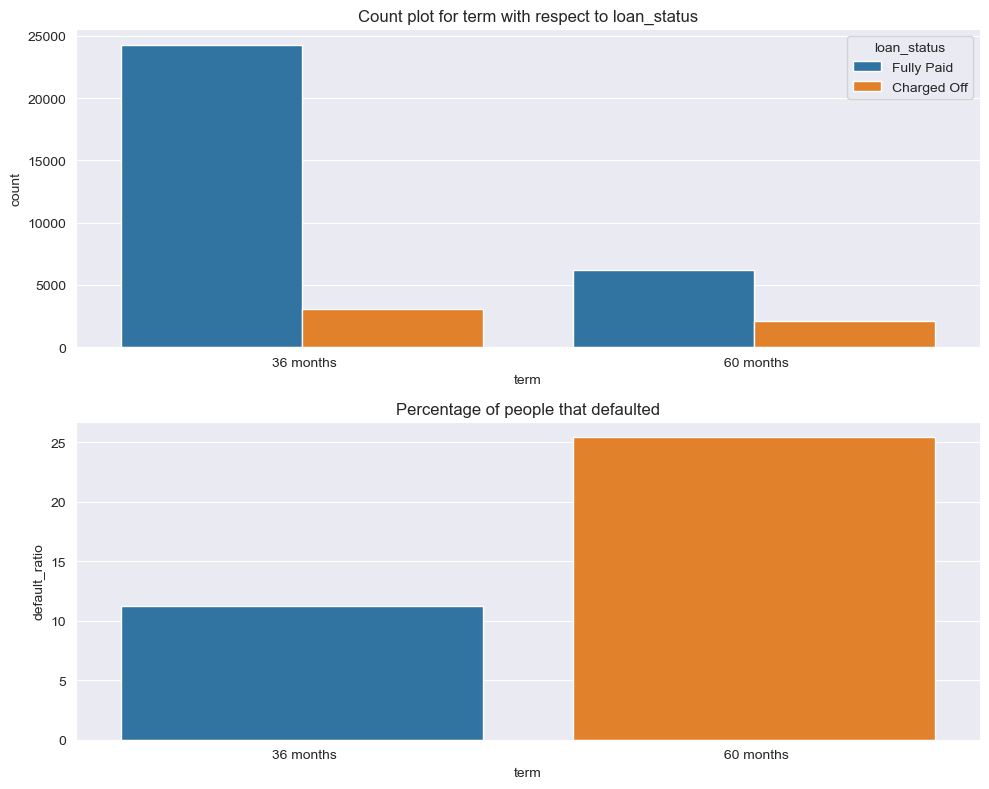

In [48]:
plotForCategoricalVariables(df, 'term')

The term does not seem to be a strong indicator of default, but its noteworthy that customers with a 60 month term have a 25% chance of default.

## Annual_Inc

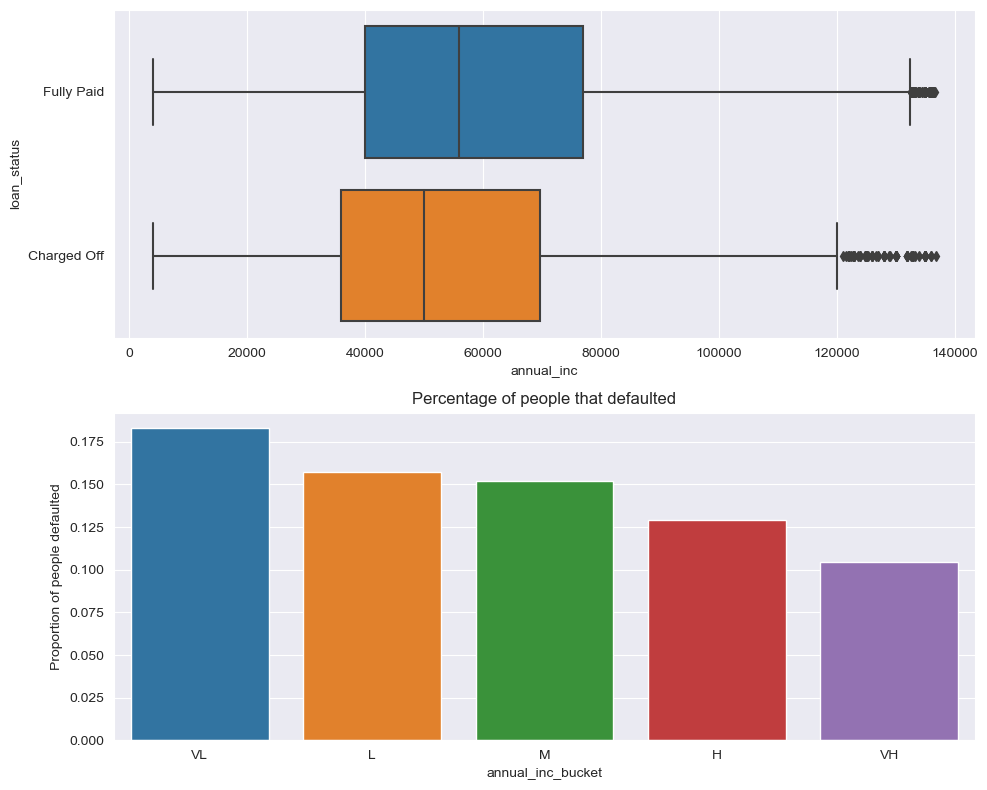

In [49]:
plotForNumericVariables(df, 'annual_inc')

In [50]:
df[df['loan_status']=='Charged Off']['annual_inc'].describe()

count      5184.000000
mean      54758.705282
std       25347.480746
min        4080.000000
25%       36000.000000
50%       50000.000000
75%       69600.000000
max      136886.000000
Name: annual_inc, dtype: float64

In [51]:
df[df['loan_status']!='Charged Off']['annual_inc'].describe()

count     30453.000000
mean      60482.576232
std       26935.472035
min        4000.000000
25%       40000.000000
50%       56000.000000
75%       77000.000000
max      136625.000000
Name: annual_inc, dtype: float64

The median value for annual_inc for people who defaulted is less than people who paid the loans. The second graph also indicates that as the annual_inc increases, the chances of default decreases. **A higher annual income would mean that, the more the savings the customer can make towards the loan and hence a higher chance that the loan is paid**.

## Installments

In [52]:
df['installment'].corr(df['loan_amnt'])

0.928758092115028

Higher the loan_amnt, higher the installment to pay monthly, hence we ignore this column.

## Grade

In [53]:
df['grade'].isna().sum()

0

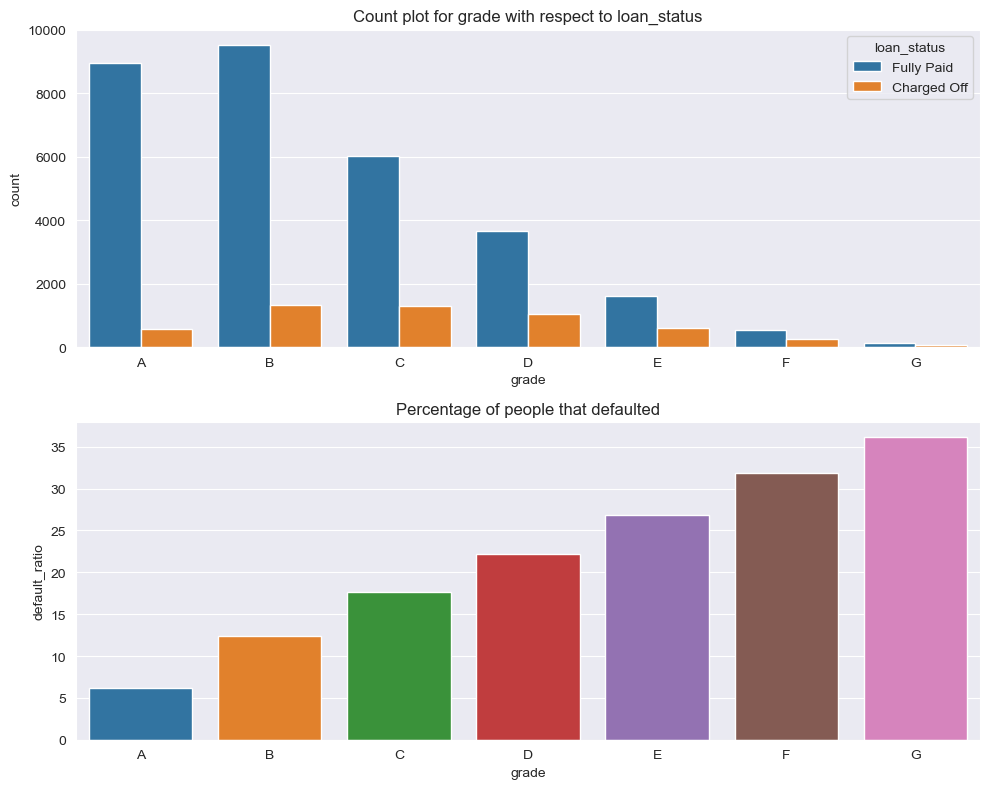

In [54]:
plotForCategoricalVariables(df, 'grade')

Grade is an ordered categorical variable. The second graph clearly indicates that as the grade increases alphabetically the higher the chance of default. **Higher grade means higher risk, which clearly indicates a higher chance that the customer defaults**.

## sub_grade

In [55]:
df['sub_grade'].isna().sum()

0

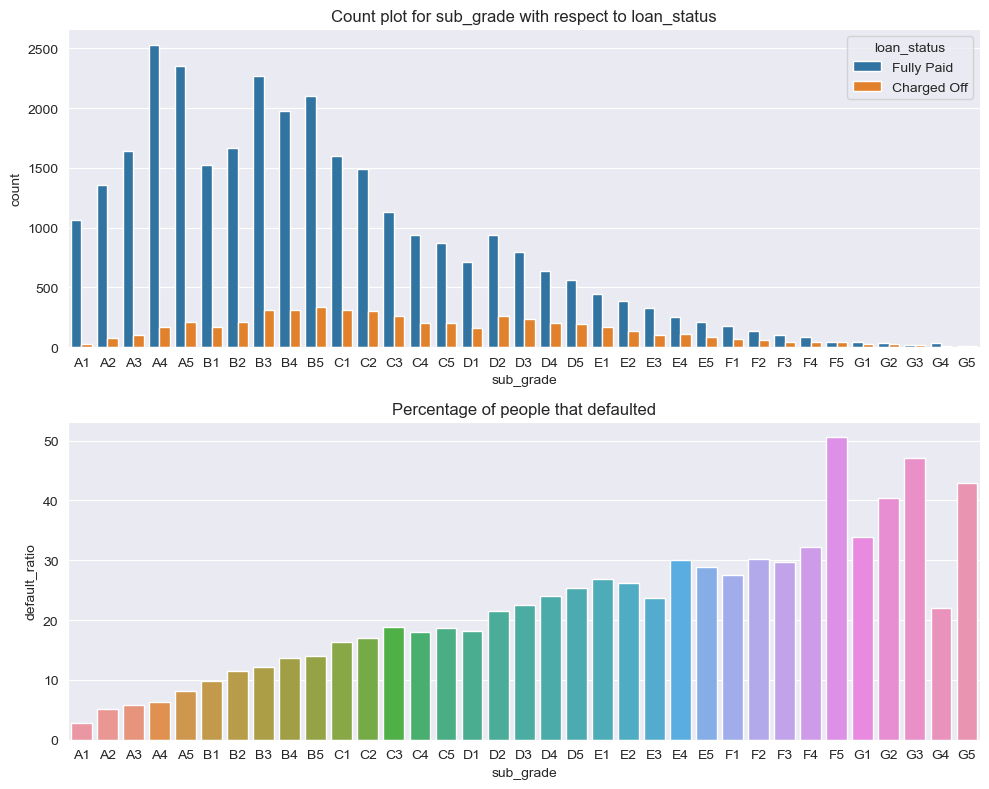

In [56]:
plotForCategoricalVariables(df, 'sub_grade')

sub_grade is an ordered categorical variable. Within a grade as the number increases the higher the chance of risk. A5 is more riskier than A4 is more riskier than A3 and so on. You can see this trend in the second graph. Although, there are a few exceptions the trend is maintained convincingly. **Higher the subgrade within a grade, higher the chance that a customer defaults**.

## Emp_Title

In [57]:
df['emp_title'].isna().sum()

2140

## emp_length

In [58]:
df['emp_length'].isna().sum()

1002

In [59]:
df['emp_length'].value_counts()

10+ years    7481
< 1 year     4243
2 years      4034
3 years      3745
4 years      3122
1 year       2997
5 years      2966
6 years      2020
7 years      1599
8 years      1298
9 years      1130
Name: emp_length, dtype: int64

In [60]:
df['emp_length'] =  df['emp_length'].astype('str')

In [61]:
df['emp_length'] = df['emp_length'].apply(lambda x: x.replace('< ', '0-'))
df['emp_length'] = df['emp_length'].apply(lambda x: x.replace(' years', ''))
df['emp_length'] = df['emp_length'].apply(lambda x: x.replace(' year', ''))
df['emp_length'] = df['emp_length'].apply(lambda x: x.replace('+', ''))

temp_df = df[df['emp_length']!='nan']

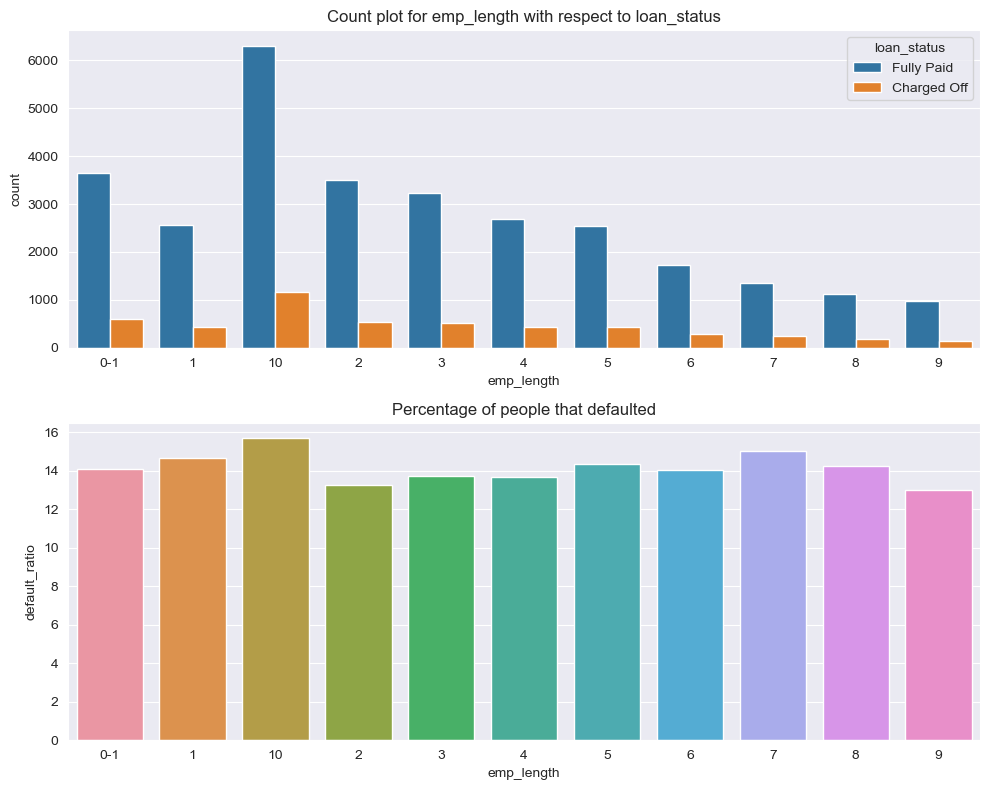

In [62]:
plotForCategoricalVariables(temp_df, 'emp_length')

There is not a lot of difference in the percentage of people who defaulted with the employment length

## Home Ownership

In [63]:
df['home_ownership'].isna().sum()

0

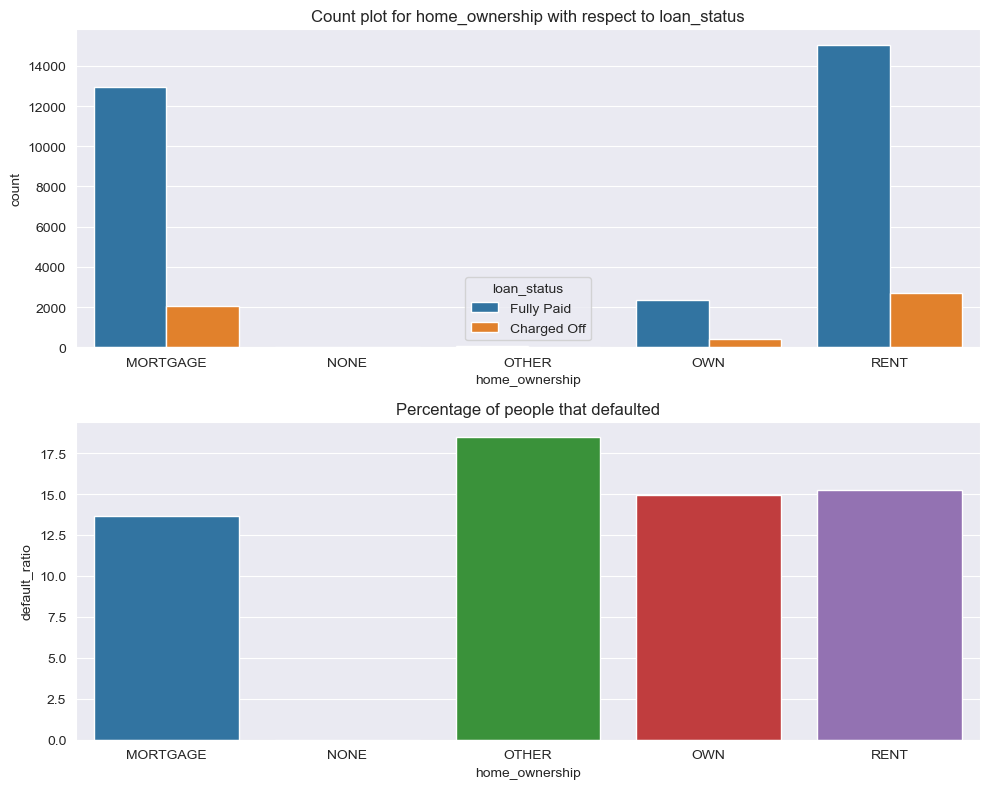

In [64]:
plotForCategoricalVariables(df, 'home_ownership')

There is not a lot of difference in the percentage of people who defaulted with the home_ownership.

## Verification_Status

In [65]:
df['verification_status'].isna().sum()

0

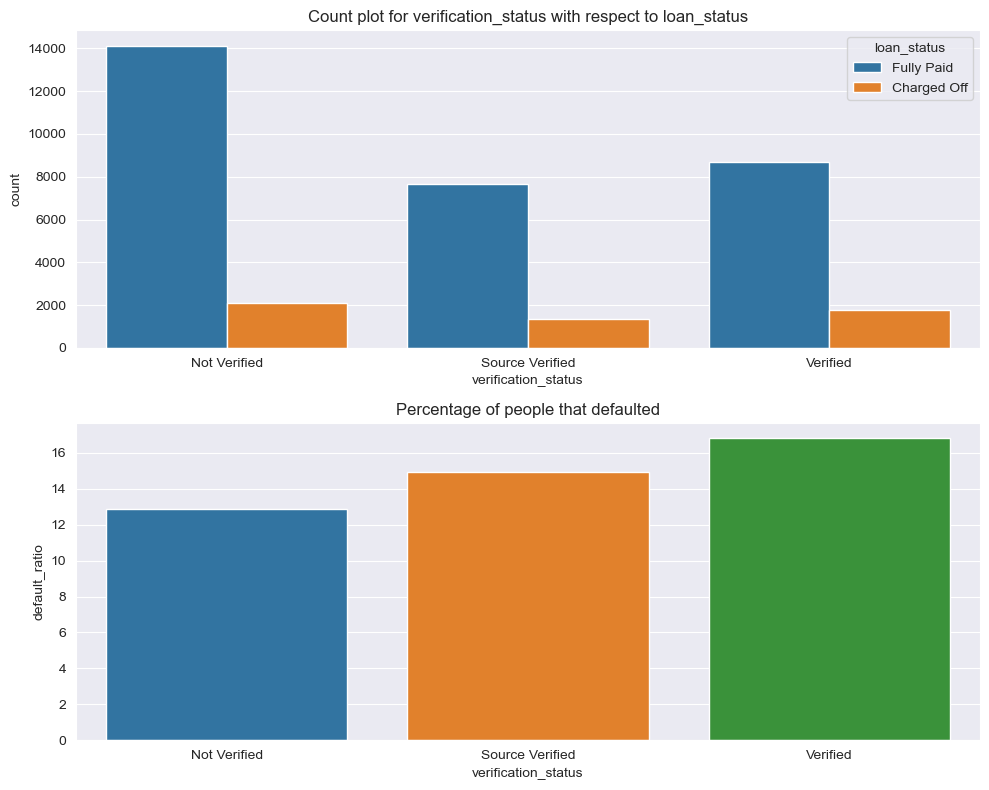

In [66]:
plotForCategoricalVariables(df, 'verification_status')

No indicators

## Purpose

In [67]:
df['purpose'].isna().sum()

0

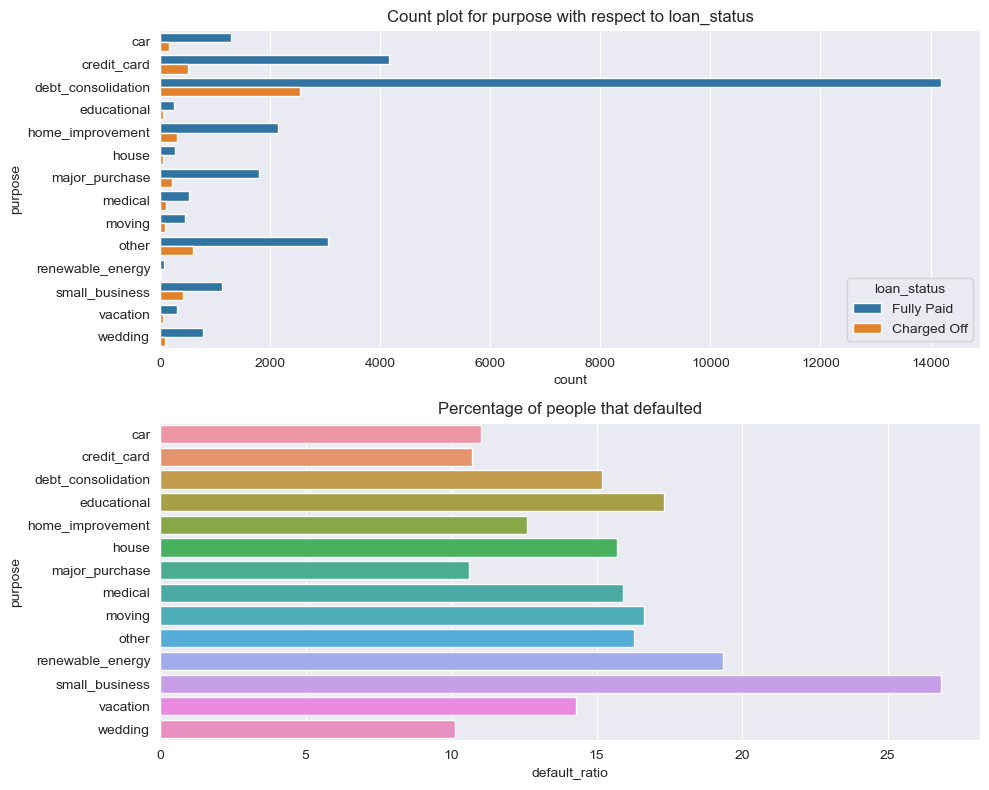

In [68]:
plotForCategoricalVariablesYAxis(df, 'purpose')

Around 28% of small businesses result in the loan

## Addr_State

In [69]:
df['addr_state'].isna().sum()

0

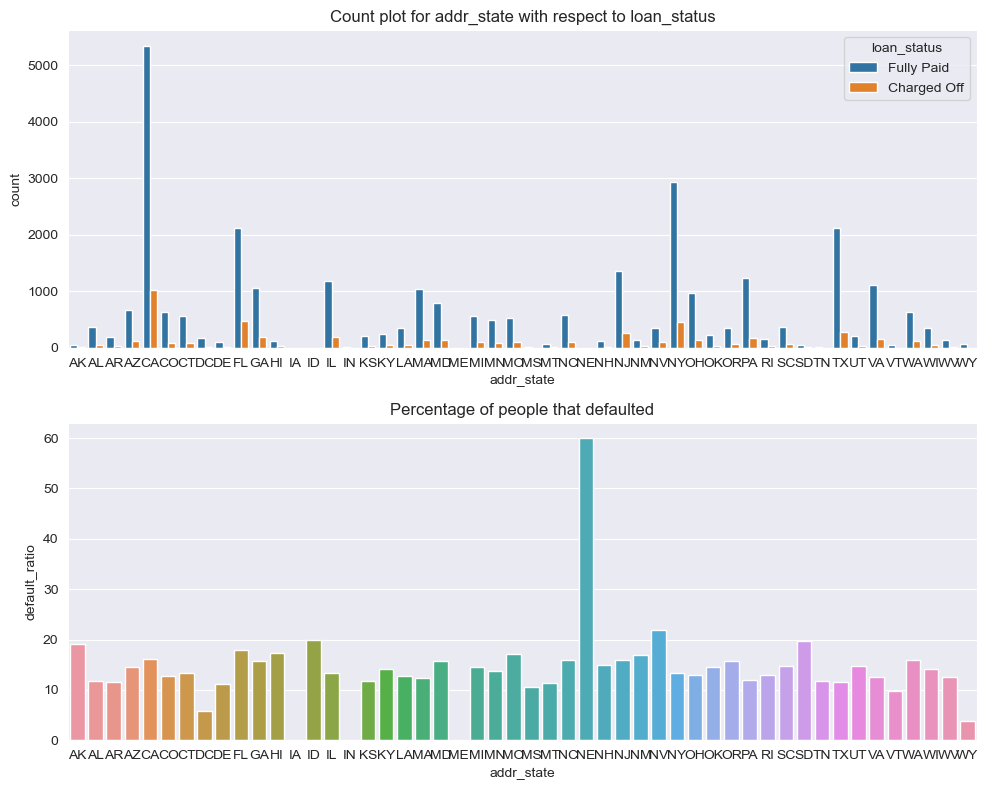

In [70]:
plotForCategoricalVariables(df, 'addr_state')

In [71]:
gatherProportions(df, sorted(df['addr_state'].unique()), 'addr_state').sort_values(by='default_ratio', ascending=False)

,addr_state,default_ratio,non_default_ratio
28,NE,60.000000,40.000000
32,NV,21.846847,78.153153
13,ID,20.000000,80.000000
40,SD,19.672131,80.327869
0,AK,19.117647,80.882353
9,FL,18.003084,81.996916
11,HI,17.307692,82.692308
24,MO,17.115689,82.884311
31,NM,16.860465,83.139535
4,CA,16.146731,83.853269


We see that Nebraska has 60% default ratio which is the maximum default ratio for any state.

In [72]:
len(df[df['addr_state']=='NE'])

5

But, it turns out that there are only 5 rows that are based on Nebraska which is not enough to derive a conclusuion.

## DTI

Debt to Income ratio compares how much you owe to how much you spend every year. A low DTI means that your earnings are much higher than your expenditure.

In [73]:
df['dti'].isna().sum()

0

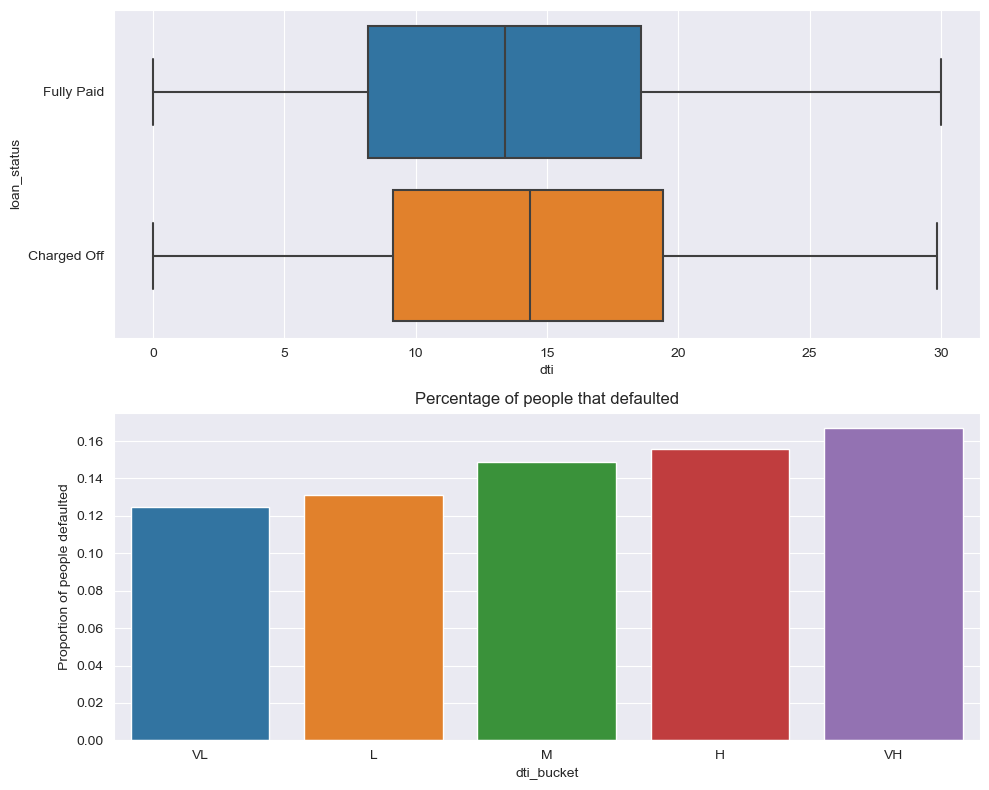

In [74]:
plotForNumericVariables(df, 'dti')

The median dti for people who defaulted is slightly higher than the median dti of people who paid the loans indicating that people who failed to pay their loans owed more each month in comparison to their income than the people who completed their loans. The second graph also shows that as the DTI increases, the percentage of people who default also increases. **DTI is a good indicator of the financial situation of the person, the lower the DTI, the more they are able to save and higher the chances that their loan is repaid.**

## Open Accounts

In [75]:
df['open_acc'].isna().sum()

0

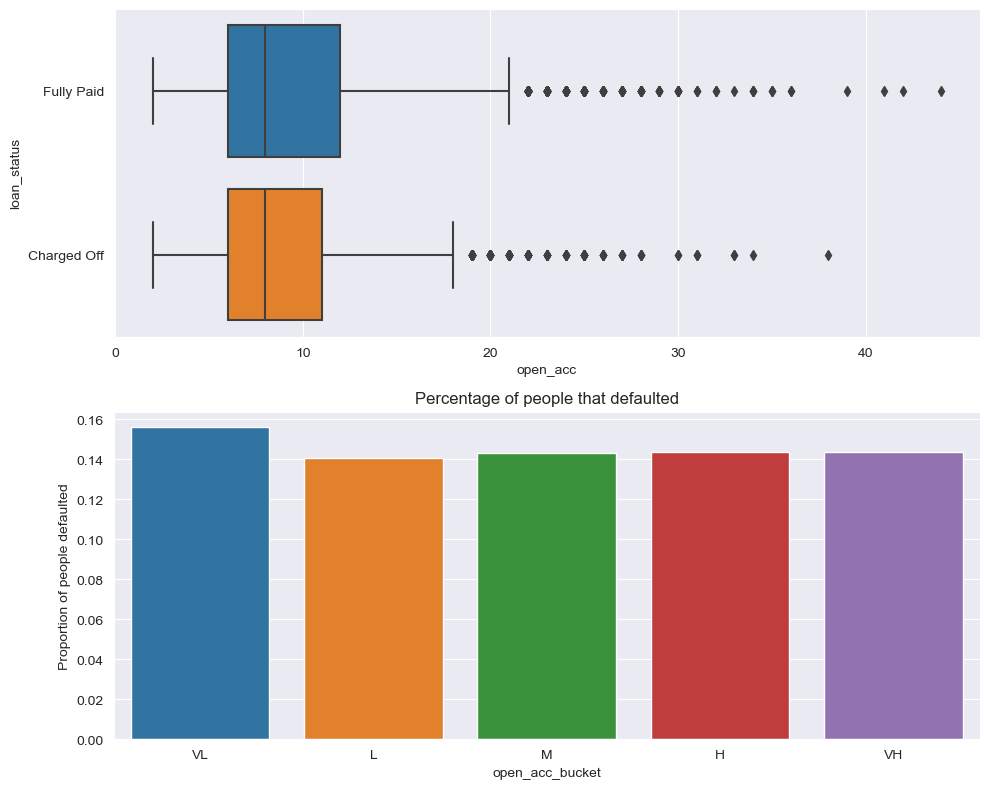

In [76]:
plotForNumericVariables(df, 'open_acc')

Relatively same median values, not a lot of difference because of the number of open accounts.

## pub_rec

In [77]:
df['pub_rec'].isna().sum()

0

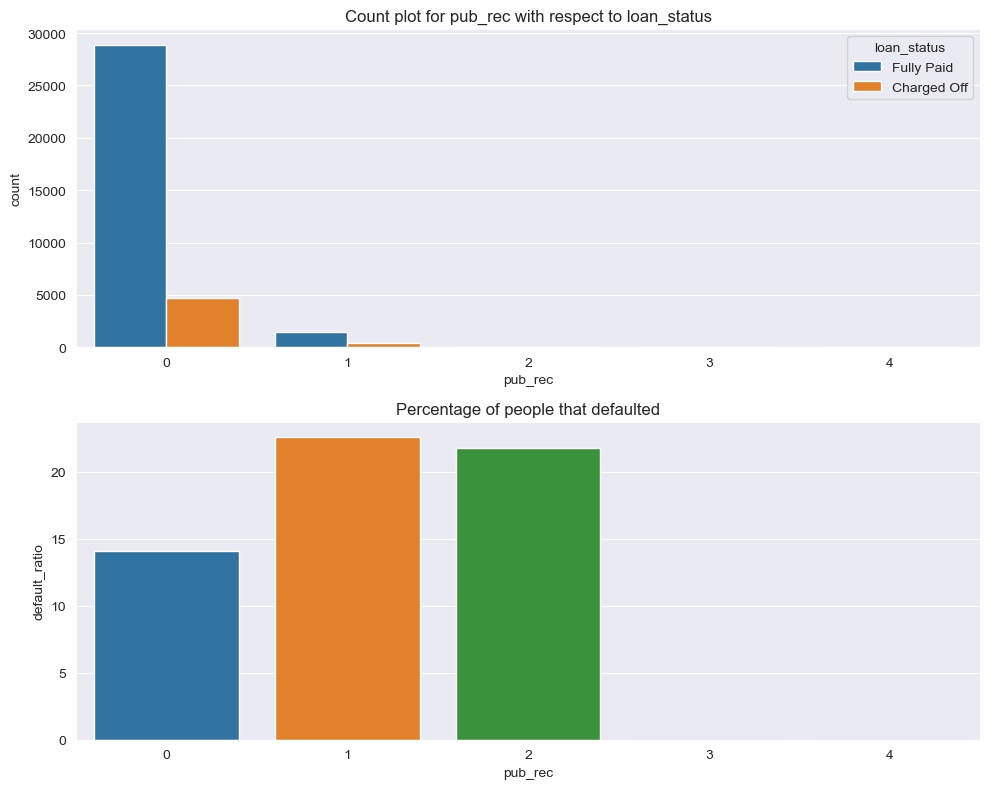

In [78]:
plotForCategoricalVariables(df, 'pub_rec')

In [79]:
df['pub_rec'].value_counts()

0    33647
1     1936
2       46
3        6
4        2
Name: pub_rec, dtype: int64

There are too few derogatory records greater than 1. For 1 derogatory record, around 22% of people have defaulted.

## revol_bal

In [80]:
df['revol_bal'].isna().sum()

0

<Axes: xlabel='revol_bal'>

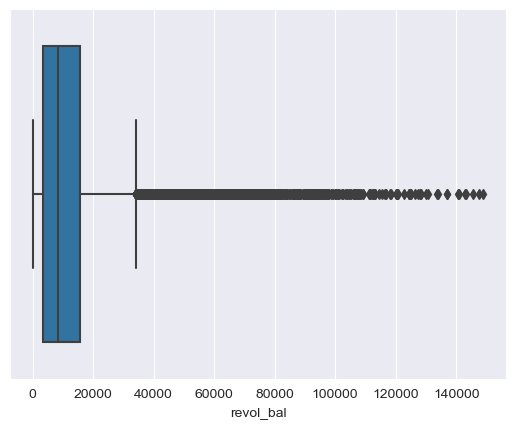

In [81]:
sns.boxplot(x=df['revol_bal'])

In [82]:
np.quantile(df['revol_bal'], 0.95)

35377.399999999994

C:\Users\davadhani\AppData\Local\Temp\ipykernel_30532\3394156515.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
C:\Users\davadhani\AppData\Local\Temp\ipykernel_30532\3394156515.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(col1+'_bucket', axis=1, inplace=True)


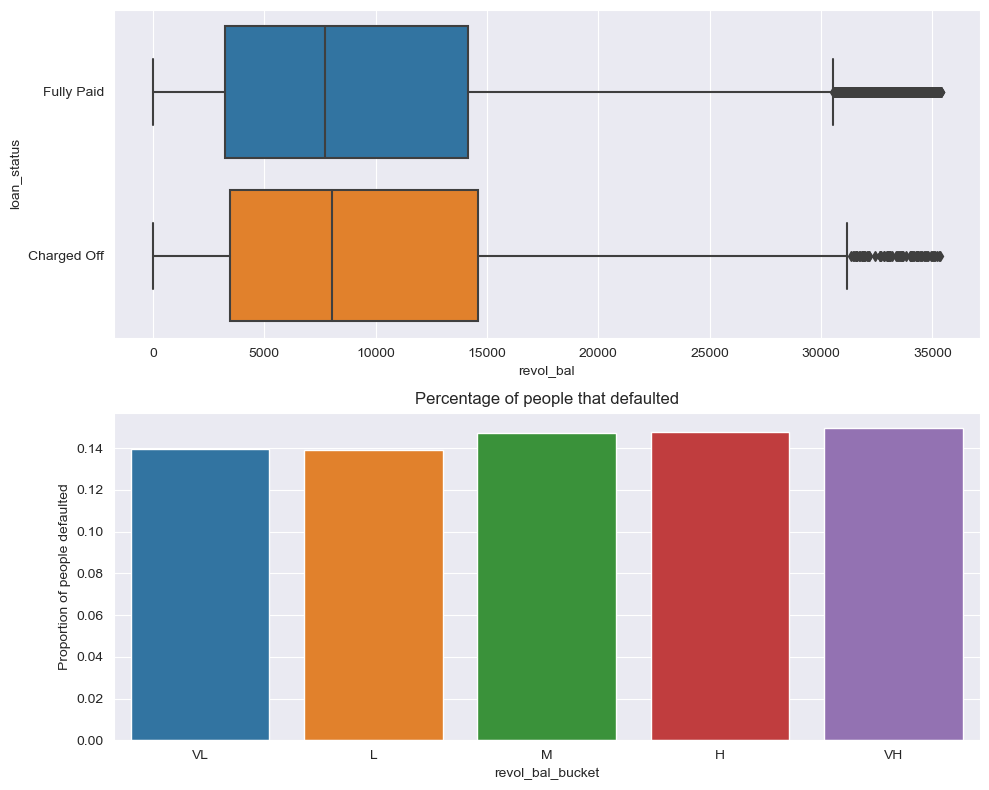

In [83]:
plotForNumericVariables(df[df['revol_bal']<35377], 'revol_bal')

No significant difference with revol_bal

## Revol_Util

Revolving utilization compares the balance on each of your credit cards to your credit limit.

In [84]:
df['revol_util'].isna().sum()

48

<Axes: xlabel='revol_util'>

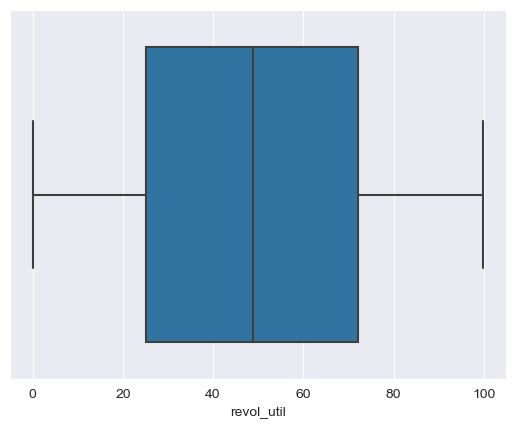

In [85]:
sns.boxplot(x=df['revol_util'])

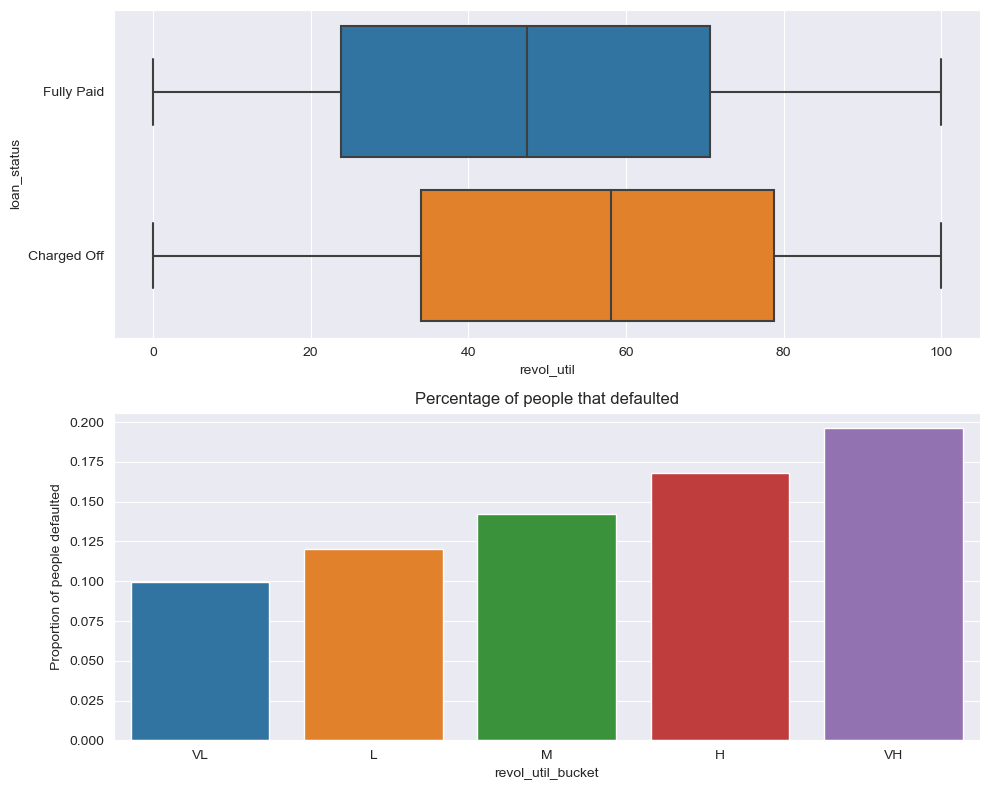

In [86]:
plotForNumericVariables(df, 'revol_util')

In [87]:
df[df['loan_status']=='Charged Off']['revol_util'].describe()

count    5168.000000
mean       55.321976
std        27.902949
min         0.000000
25%        34.000000
50%        58.100000
75%        78.725000
max        99.900000
Name: revol_util, dtype: float64

In [88]:
df[df['loan_status']!='Charged Off']['revol_util'].describe()

count    30421.000000
mean        47.449611
std         28.188689
min          0.000000
25%         23.900000
50%         47.400000
75%         70.600000
max         99.900000
Name: revol_util, dtype: float64

Median value for `revol_util` for people who defaulted is 58% which is much higher then 47% revol_util for people who have paid their loans. Indicating that people who default usually have a much higher creadit utilization. **Higher the creadit utilization, higher the chance that the customer might default which is evident from both graphs**.

## Total accounts

In [89]:
df['total_acc'].isna().sum()

0

<Axes: xlabel='total_acc'>

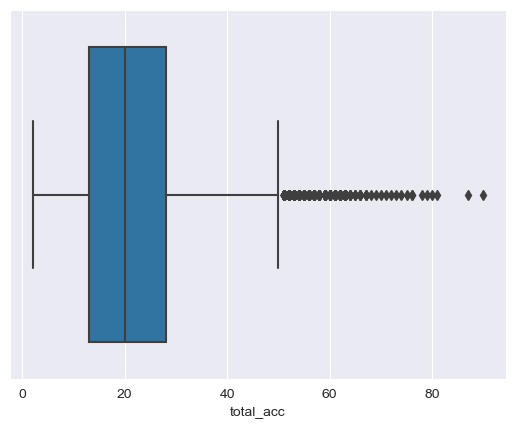

In [90]:
sns.boxplot(x=df['total_acc'])

C:\Users\davadhani\AppData\Local\Temp\ipykernel_30532\3394156515.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
C:\Users\davadhani\AppData\Local\Temp\ipykernel_30532\3394156515.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(col1+'_bucket', axis=1, inplace=True)


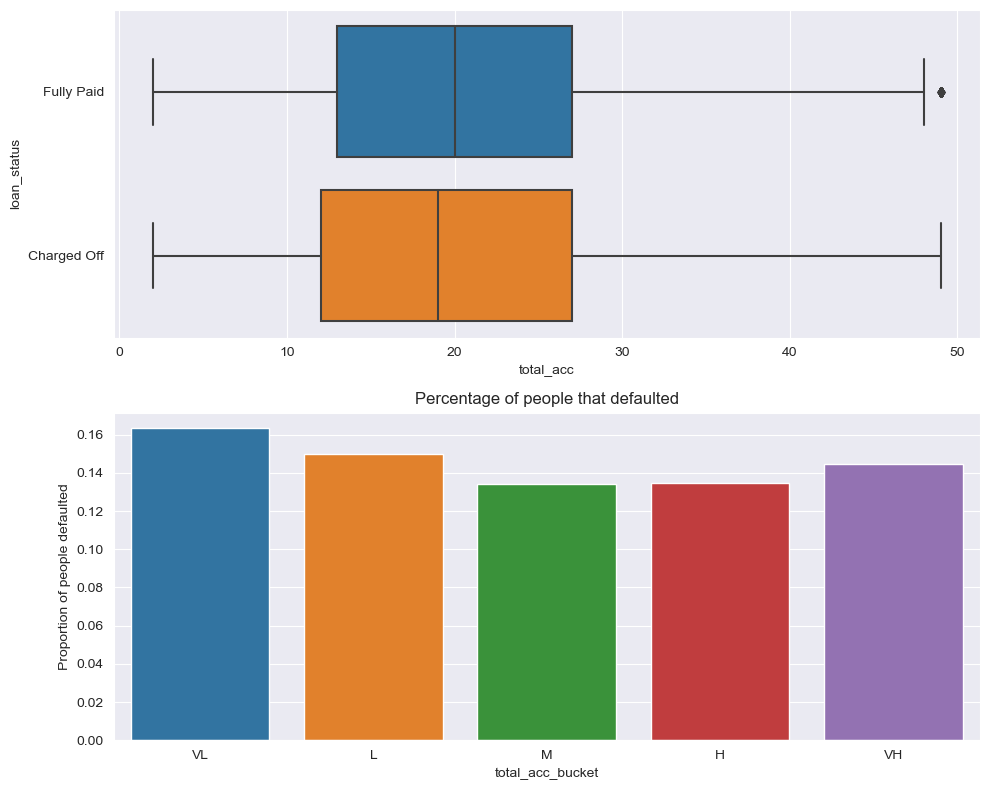

In [91]:
plotForNumericVariables(df[df['total_acc']<50],'total_acc')

No strong trend

## total_rec_late_fee

In [92]:
df['total_rec_late_fee'].isna().sum()

0

<Axes: xlabel='total_rec_late_fee'>

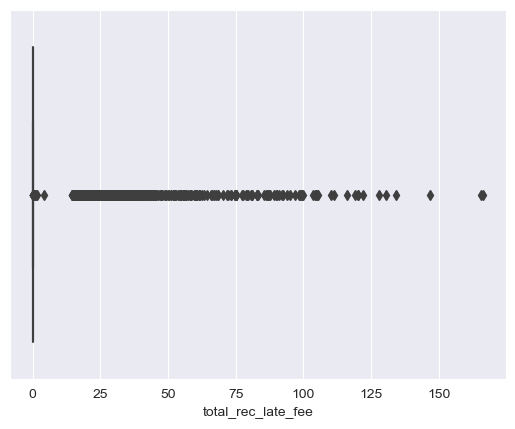

In [93]:
sns.boxplot(x=df['total_rec_late_fee'])

Under most scenarios the late fees paid is 0. However, let's see of the people who have paid the late fees, how many of them default.

C:\Users\davadhani\AppData\Local\Temp\ipykernel_30532\3394156515.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
C:\Users\davadhani\AppData\Local\Temp\ipykernel_30532\3394156515.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(col1+'_bucket', axis=1, inplace=True)


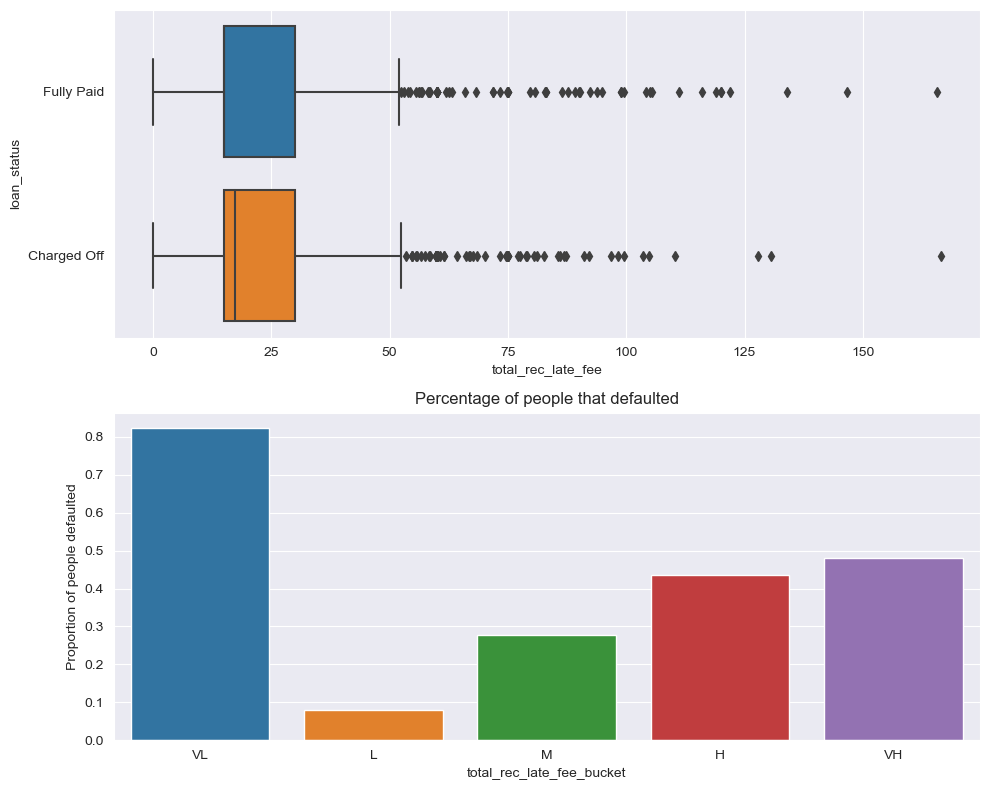

In [94]:
plotForNumericVariables(df[df['total_rec_late_fee']>0], 'total_rec_late_fee')

## pub_rec_bankruptcies

In [95]:
df['pub_rec_bankruptcies'].isna().sum()

657

In [96]:
df['pub_rec_bankruptcies'].value_counts()

0.0    33400
1.0     1575
2.0        5
Name: pub_rec_bankruptcies, dtype: int64

Let us just check the default ratio for `pub_rec_bankruptcies` equal to 1

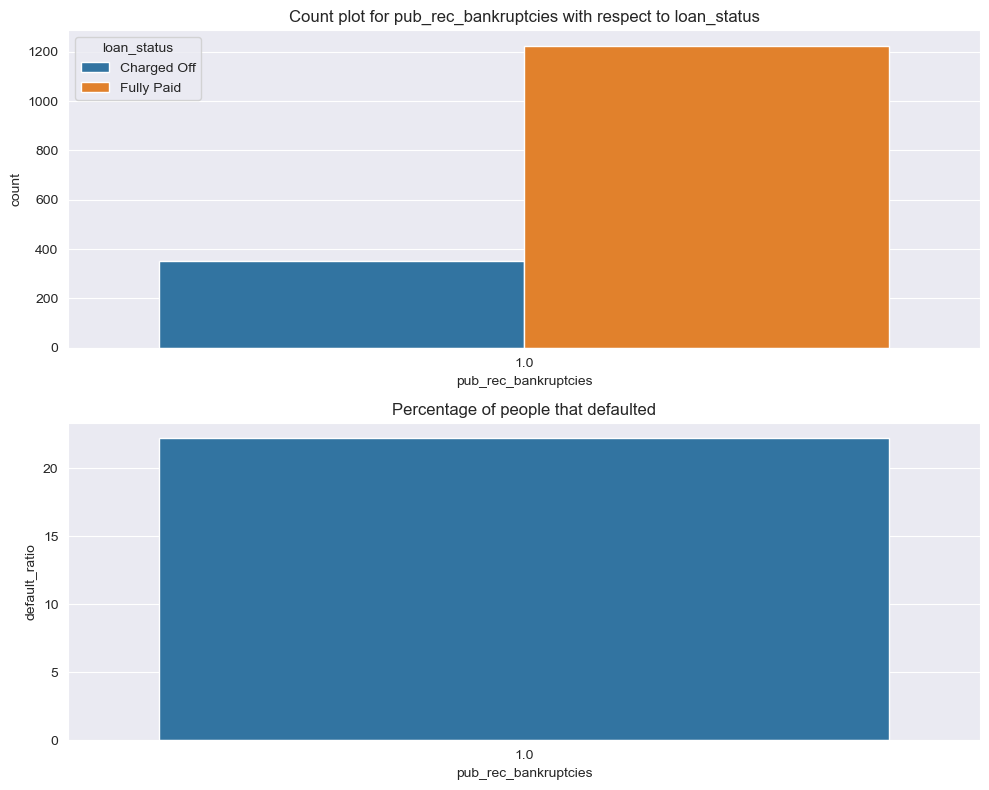

In [97]:
plotForCategoricalVariables(df[df['pub_rec_bankruptcies']==1], 'pub_rec_bankruptcies')

NO STRONG TREND

# Data Driven Metrics

There are 2 possible metrics that can be derived from the existing data given to us.
1) What percent of the loan amnt is the customer's salary which is a data driven metric.The higher the percentage of the loan amount with respect to income, we expect that the percentage of default might increase too.
2) Derive day, month and year from date and evaluate the results.

In [98]:
df['percent'] = (df['loan_amnt']/df['annual_inc'])*100

## Percent

<Axes: xlabel='percent'>

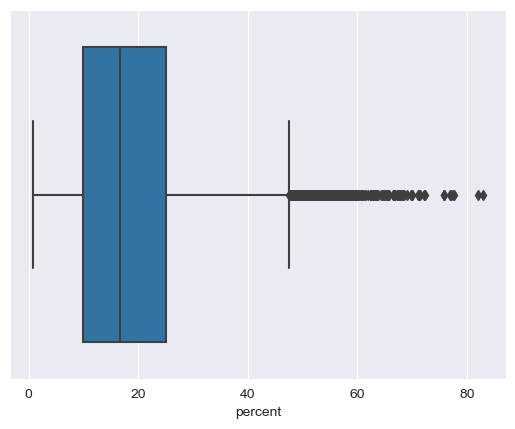

In [99]:
sns.boxplot(x=df['percent'])

C:\Users\davadhani\AppData\Local\Temp\ipykernel_30532\3394156515.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
C:\Users\davadhani\AppData\Local\Temp\ipykernel_30532\3394156515.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(col1+'_bucket', axis=1, inplace=True)


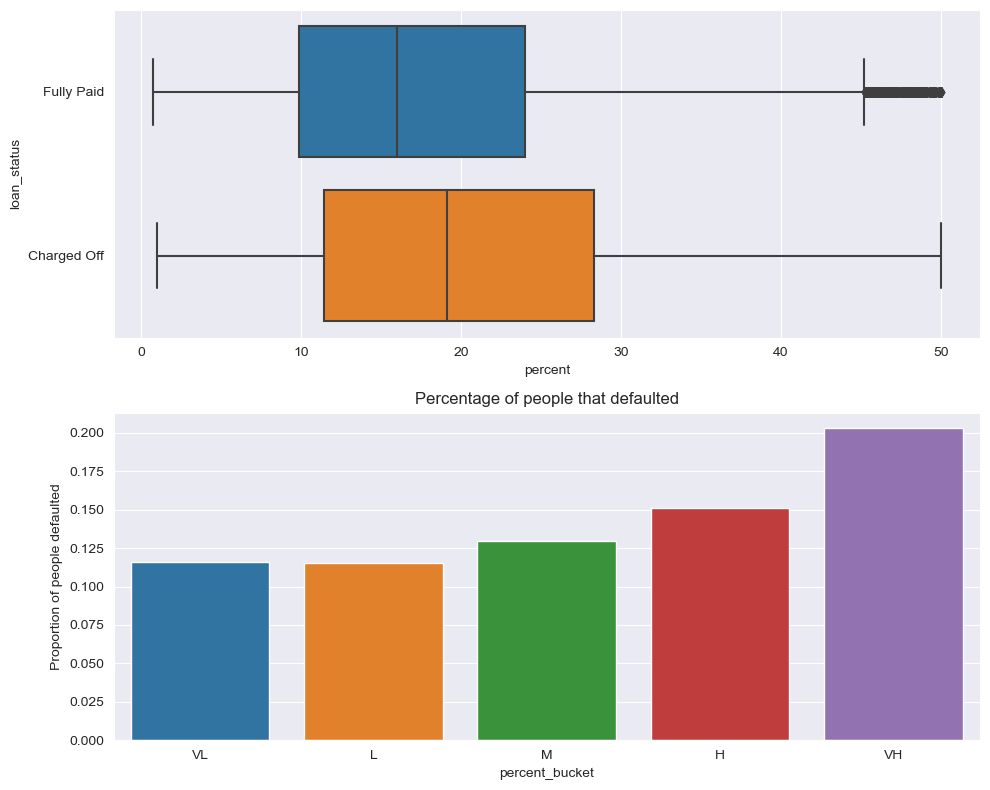

In [100]:
plotForNumericVariables(df[df['percent']<50], 'percent')

As a higher percentage of income is provided as a loan, the higher the percentage of default.

## Issued Date

In [101]:
from datetime import datetime
import calendar
df['month']=df['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%y').strftime('%b'))

In [102]:
df['year']=df['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%y').strftime('%y'))

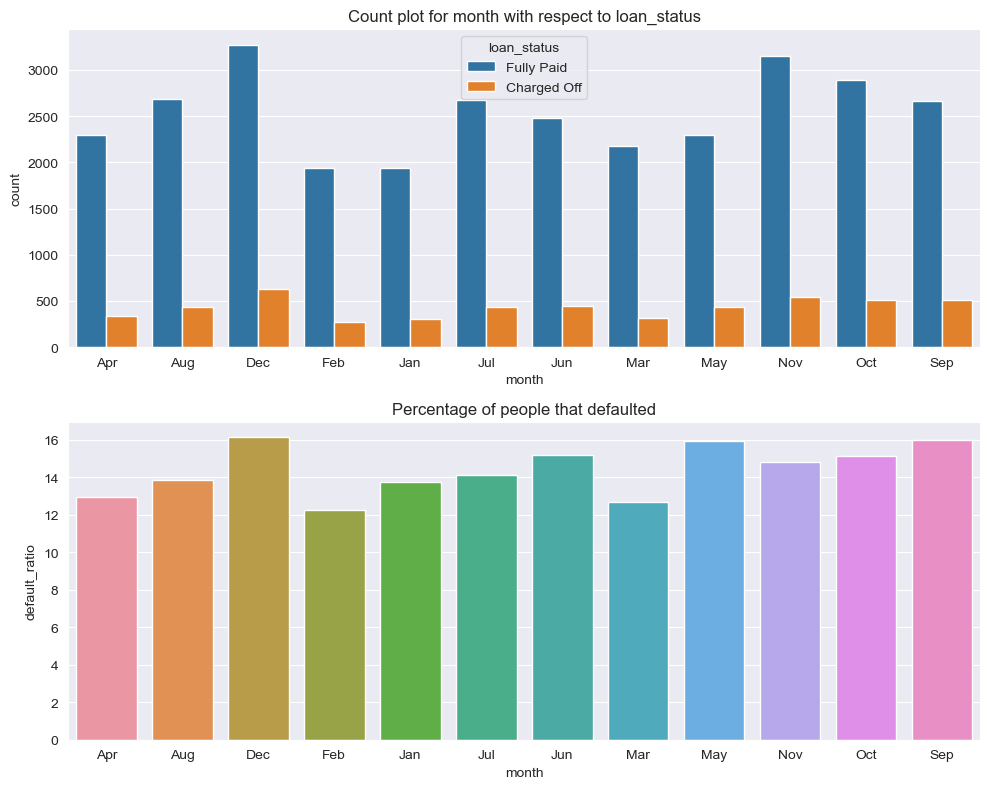

In [103]:
plotForCategoricalVariables(df, 'month')

THERE SEEM TO BE NO OBSERVABLE TRENDS WITH RESPECT TO MONTH

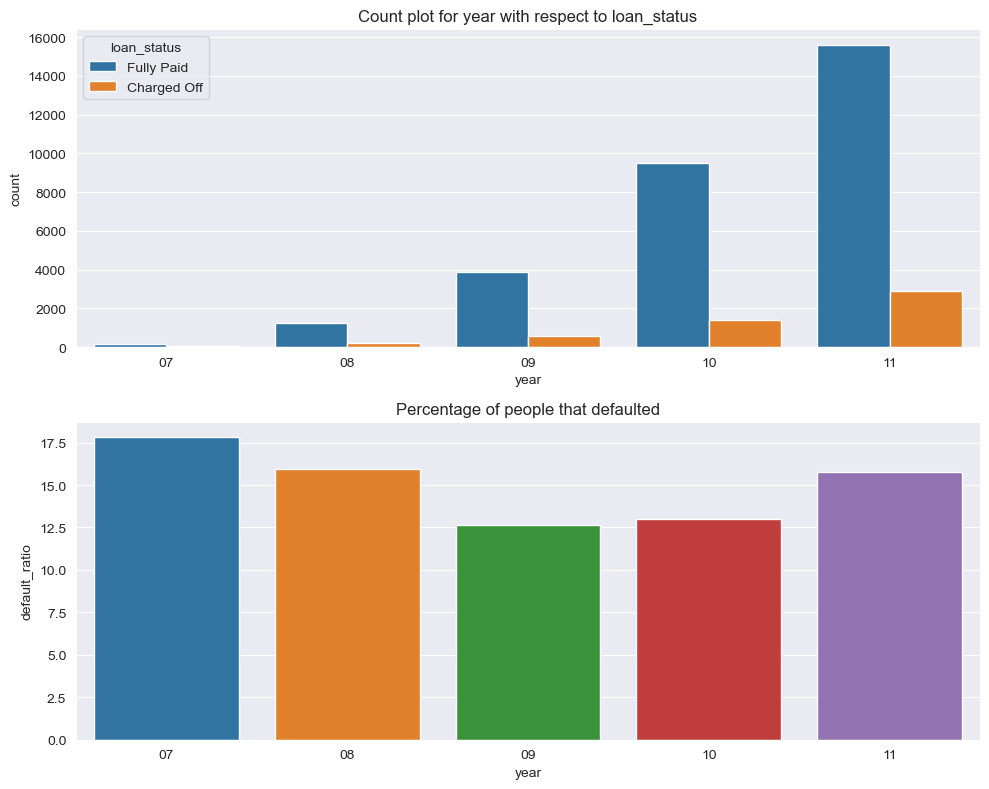

In [104]:
plotForCategoricalVariables(df, 'year')

There are no clear trends here.

## Bivariate analysis

For bivariate analysis of variables, we usually use scatter plots, but due to the data being skewed here, there wouldn't be a lot of insights that we can draw from scatter plots. Hence, we will mostly use pivot tables and heat maps by converting numeric values into categorical values using pandas qdcut. We will first write a custom function that will plot the heatmap for us. Just like univariate analysis, we will try and look at the percentage of people that defaulted rather than the count.

In [105]:
def plotHeatMap(col1, col2):
    df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
    df[col2+'_bucket']=pd.qcut(df[col2], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
    paid_pivot = pd.pivot_table(data=df[df['loan_status']=='Fully Paid'], index=col1+'_bucket', columns=col2+"_bucket", values='id', aggfunc='count')
    default_pivot = pd.pivot_table(data=df[df['loan_status']=='Charged Off'], index=col1+'_bucket', columns=col2+'_bucket', values='id', aggfunc='count')
    proportion_df = default_pivot.divide(paid_pivot.add(default_pivot))
    sns.heatmap(proportion_df, cmap='Greens')
    plt.show()
    return proportion_df

In [106]:
def plotHeatMapNumericCategorical(col1, col2):
    df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
    paid_pivot = pd.pivot_table(data=df[df['loan_status']=='Fully Paid'], index=col1+'_bucket', columns=col2, values='id', aggfunc='count')
    default_pivot = pd.pivot_table(data=df[df['loan_status']=='Charged Off'], index=col1+'_bucket', columns=col2, values='id', aggfunc='count')
    proportion_df = default_pivot.divide(paid_pivot.add(default_pivot))
    proportion_df.index = pd.CategoricalIndex(proportion_df.index, categories= ["VL", "L", "M", "H", "VH"])
    sns.heatmap(proportion_df, cmap='Greens')
    plt.show()
    return proportion_df

In [107]:
def plotHeatMapCategorical(col1, col2):
    paid_pivot = pd.pivot_table(data=df[df['loan_status']=='Fully Paid'], index=col1, columns=col2, values='id', aggfunc='count')
    default_pivot = pd.pivot_table(data=df[df['loan_status']=='Charged Off'], index=col1, columns=col2, values='id', aggfunc='count')
    proportion_df = default_pivot.divide(paid_pivot.add(default_pivot))
    proportion_df.index = pd.CategoricalIndex(proportion_df.index)
    sns.heatmap(proportion_df, cmap='Greens')
    plt.show()
    return proportion_df

## Int_Rate vs Annual_Inc

The reason we would like to compare the interest rate to the annual income is because, lower annual incomes will most likely not be able to repay loans at a high interest rate. Similarly, people with a very high annual income are more likely to easily repay loans.

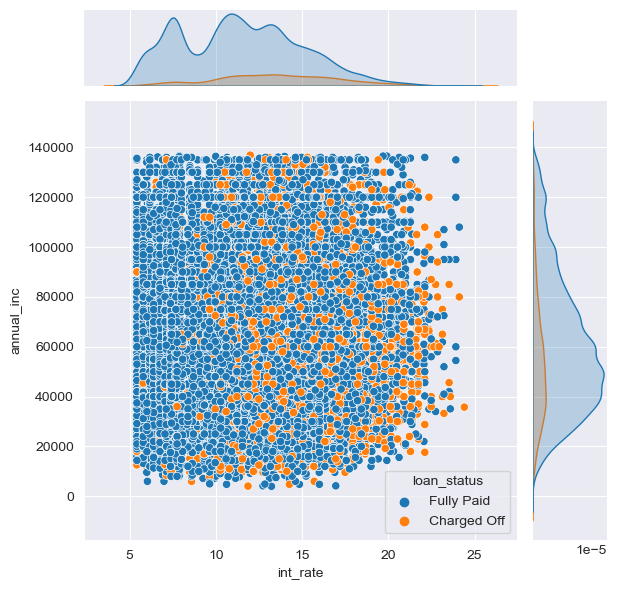

In [108]:
sns.jointplot(data=df, x='int_rate', y='annual_inc', hue='loan_status')

We can observe that at a low interest rate, very few people default. But as interest rates increase, we see default across all annual incomes. Let's evaluate the proportions using a heatmap.

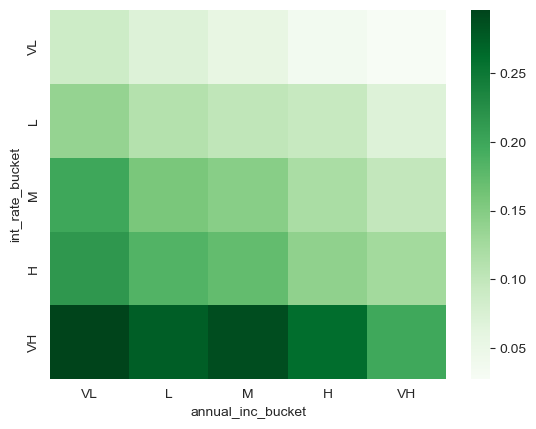

annual_inc_bucket,VL,L,M,H,VH
int_rate_bucket,,,,,
VL,0.088079,0.069474,0.056497,0.036547,0.027243
L,0.136573,0.111513,0.101025,0.094703,0.069750
M,0.198386,0.156835,0.145985,0.119777,0.097734
H,0.215565,0.184080,0.173118,0.141247,0.126453
VH,0.295993,0.274419,0.288527,0.260475,0.198020


In [109]:
plotHeatMap('int_rate','annual_inc')

This heatmap clearly shows that as interest rates increase people with lower income are more often never able to repay the loan, people with higher incomes too default but a lower percentage of them. The heatmap shows that for default **Interest rate is inversely proportional to the annual income. Lower annual income and High interest rates default. Higher annual income, lower interest rates are able to repay the loan**.

## int_rate vs grade 

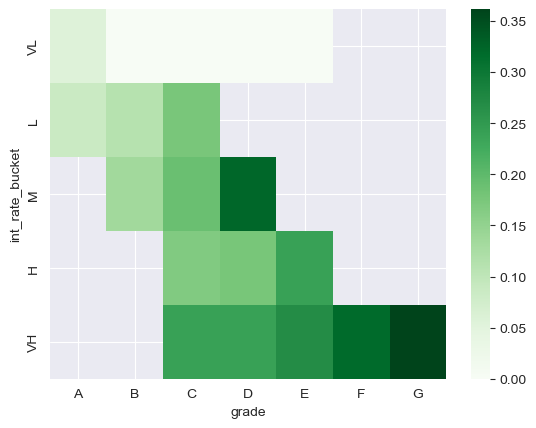

grade,A,B,C,D,E,F,G
int_rate_bucket,,,,,,,
VL,0.055358,0.000000,0.000000,0.000000,0.000000,NaN,NaN
L,0.086618,0.110199,0.176471,NaN,NaN,NaN,NaN
M,NaN,0.134478,0.189922,0.322581,NaN,NaN,NaN
H,NaN,NaN,0.167772,0.176599,0.240000,NaN,NaN
VH,NaN,NaN,0.239766,0.239224,0.269444,0.318528,0.361607


In [110]:
plotHeatMapNumericCategorical('int_rate','grade')

We already know from univariate analysis that high `int_rate` can lead to defaults. Here we also see that, at a higher interest rates, customers with a bad grades or riskier grades tend to default.

## int_rate vs sub_grade

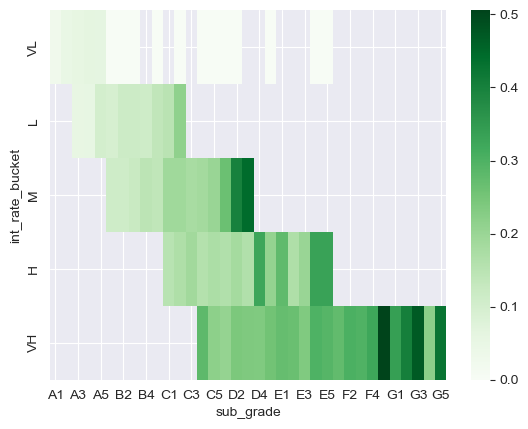

sub_grade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
int_rate_bucket,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VL,0.027447,0.050978,0.059164,0.064987,0.062549,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L,NaN,NaN,0.054054,0.056689,0.101382,0.095436,0.114935,0.115471,0.111296,0.137255,0.150000,0.214286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M,NaN,NaN,NaN,NaN,NaN,0.111570,0.110672,0.123889,0.145142,0.139840,0.190955,0.190045,0.179775,0.185714,0.200000,0.263158,0.400000,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151002,0.167630,0.188317,0.159371,0.171806,0.162662,0.182594,0.162162,0.32500,0.208333,0.277778,0.166667,0.200000,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.278689,0.218182,0.206186,0.242881,0.237754,0.23522,0.255495,0.268908,0.265469,0.236534,0.300000,0.289199,0.275,0.302564,0.297872,0.322835,0.505882,0.338028,0.403509,0.470588,0.219512,0.428571


In [111]:
plotHeatMapNumericCategorical('int_rate','sub_grade')

We already know from univariate analysis that high int_rate can lead to defaults. Here we also see that, at a higher interest rates, customers with a bad sub_grades or riskier sub_grades tend to default.

## Int_Rate vs Term

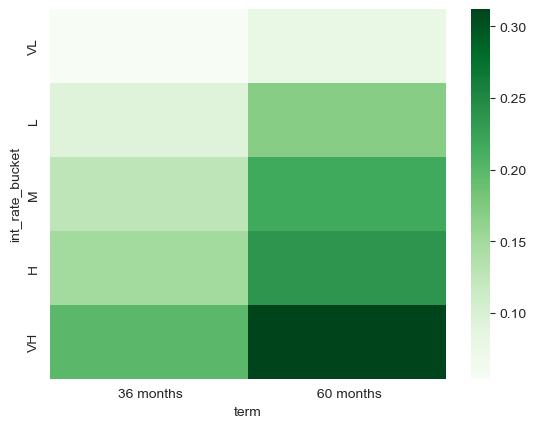

term,36 months,60 months
int_rate_bucket,,
VL,0.054099,0.080119
L,0.092716,0.169000
M,0.126294,0.217360
H,0.149398,0.237440
VH,0.198242,0.312095


In [112]:
plotHeatMapNumericCategorical('int_rate', 'term')

NO TRENDS TO OBSERVE

## Int_Rate vs Purpose

In [113]:
np.quantile(df['int_rate'],[0.2,0.4,0.6,0.8,1])

array([ 7.9 , 10.75, 12.69, 14.96, 24.4 ])

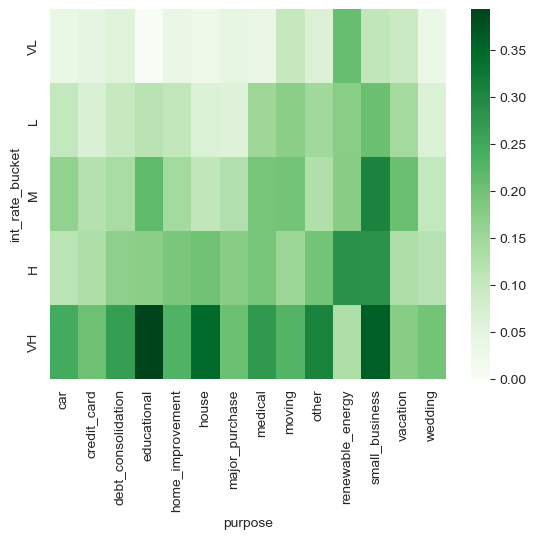

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
int_rate_bucket,,,,,,,,,,,,,,
VL,0.039832,0.046921,0.058705,0.000000,0.036517,0.028169,0.043988,0.036810,0.100775,0.067430,0.208333,0.108871,0.096491,0.033708
L,0.101449,0.067961,0.098592,0.115385,0.104508,0.064516,0.060000,0.150794,0.172727,0.147427,0.173913,0.205993,0.142857,0.067416
M,0.164557,0.121242,0.138856,0.215054,0.144708,0.107143,0.124638,0.194690,0.196429,0.127771,0.176471,0.306202,0.205882,0.102273
H,0.114286,0.129505,0.167316,0.172840,0.188862,0.200000,0.175824,0.193277,0.153061,0.196891,0.285714,0.282392,0.129630,0.119171
VH,0.244186,0.201657,0.263951,0.392857,0.230971,0.345679,0.205128,0.271930,0.228261,0.306291,0.133333,0.359140,0.176471,0.197368


In [114]:
plotHeatMapNumericCategorical('int_rate', 'purpose')

We observed during univariate analysis, that 25% of small business are not able to repay their loans. Here we can observe that these small businesses are not able to repay their loans when interest rates are medium or greater than medium. Which means that most small businesses are not able to repay the loans when interest is more than 10.75%.

It can also be observed here that very high interest rates for educational and house loans that are greater than 14.96% have a very high rate of defaults.

## Int_Rate vs Emp_Length

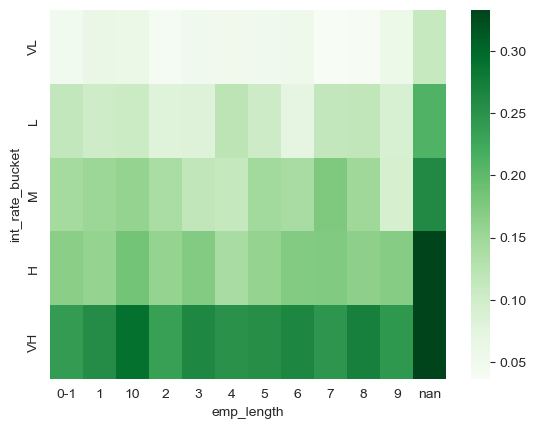

emp_length,0-1,1,10,2,3,4,5,6,7,8,9,nan
int_rate_bucket,,,,,,,,,,,,
VL,0.049322,0.063315,0.060572,0.042724,0.051047,0.051163,0.051005,0.054176,0.036036,0.039474,0.059055,0.111429
L,0.114350,0.100683,0.105263,0.080808,0.082153,0.121212,0.104505,0.072864,0.114286,0.118367,0.090476,0.210526
M,0.143026,0.151976,0.158409,0.139353,0.117260,0.112478,0.147458,0.140541,0.175953,0.148855,0.093750,0.260274
H,0.166141,0.157738,0.184892,0.159063,0.172285,0.140271,0.159049,0.172932,0.173077,0.162698,0.169811,0.333333
VH,0.238223,0.257353,0.290644,0.234395,0.264336,0.251920,0.255183,0.265854,0.246246,0.272340,0.243478,0.333333


In [115]:
plotHeatMapNumericCategorical('int_rate', 'emp_length')

It is interesting to observe here that, people who have not provided for the length of employment have defaulted with a higher proportion. The bank must make sure that the details of employments are complete and validated before provided.

## Int_Rate vs Percent

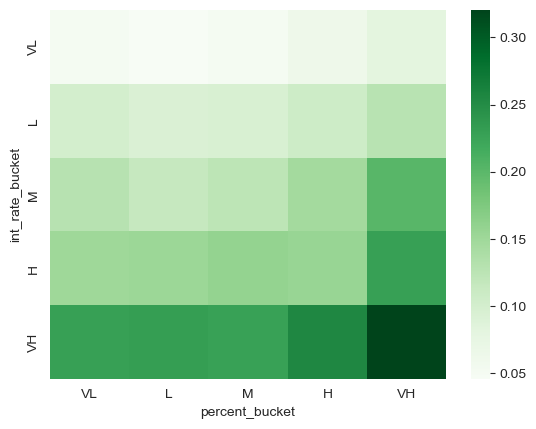

percent_bucket,VL,L,M,H,VH
int_rate_bucket,,,,,
VL,0.051467,0.045216,0.051613,0.063184,0.080931
L,0.100612,0.092881,0.095615,0.106781,0.127572
M,0.128706,0.115413,0.122884,0.146341,0.201592
H,0.150665,0.152318,0.158554,0.155482,0.228972
VH,0.228300,0.230342,0.227545,0.255090,0.320698


In [116]:
plotHeatMap('int_rate', 'percent')

NO TRENDS TO OBSERVE

## Int_Rate vs Revol_Util

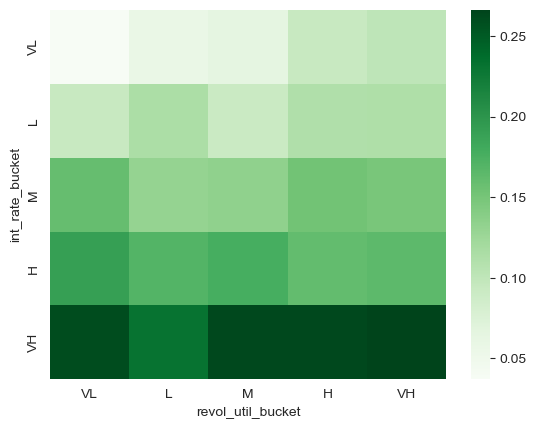

revol_util_bucket,VL,L,M,H,VH
int_rate_bucket,,,,,
VL,0.037002,0.058213,0.065167,0.093960,0.100962
L,0.093956,0.114725,0.091877,0.111732,0.112971
M,0.159132,0.130316,0.133777,0.152820,0.148571
H,0.190672,0.170273,0.176821,0.161473,0.164496
VH,0.260504,0.231988,0.263389,0.262787,0.266321


In [117]:
plotHeatMap('int_rate', 'revol_util')

NO TRENDS TO OBSERVE

## Int_Rate vs Home_Ownership

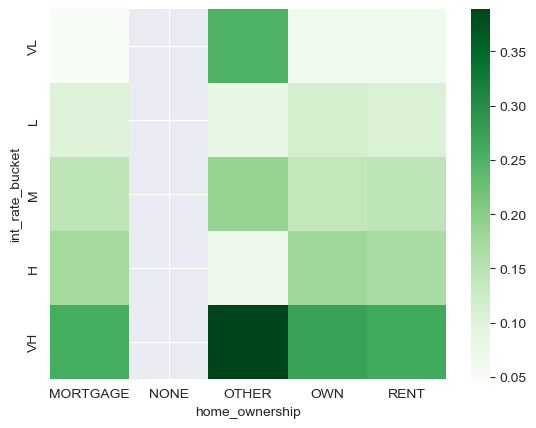

home_ownership,MORTGAGE,NONE,OTHER,OWN,RENT
int_rate_bucket,,,,,
VL,0.048445,NaN,0.250000,0.063540,0.062005
L,0.100864,NaN,0.083333,0.116190,0.104751
M,0.145212,NaN,0.187500,0.139963,0.143636
H,0.172769,NaN,0.071429,0.178108,0.167379
VH,0.258053,NaN,0.388889,0.273077,0.262047


In [118]:
plotHeatMapNumericCategorical('int_rate', 'home_ownership')

NO TRENDS TO OBSERVE

## Annual_Inc vs Term

In [119]:
np.quantile(df['annual_inc'], [0,0.2,0.4,0.6,0.8,1])

array([  4000.   ,  36000.   ,  49215.816,  62000.   ,  81400.   ,
       136886.   ])

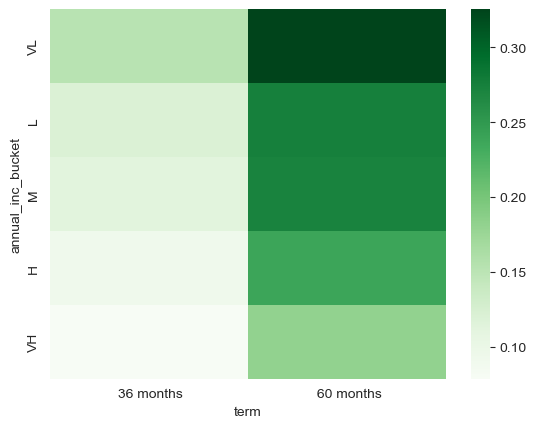

term,36 months,60 months
annual_inc_bucket,,
VL,0.152579,0.325599
L,0.120821,0.275015
M,0.113228,0.272521
H,0.092208,0.238362
VH,0.078567,0.181717


In [120]:
plotHeatMapNumericCategorical('annual_inc', 'term')

For a low income range less than 49000 dollars, when term is 60 months, there is a fair percentage of people that default.

## Annual_Inc vs Grade

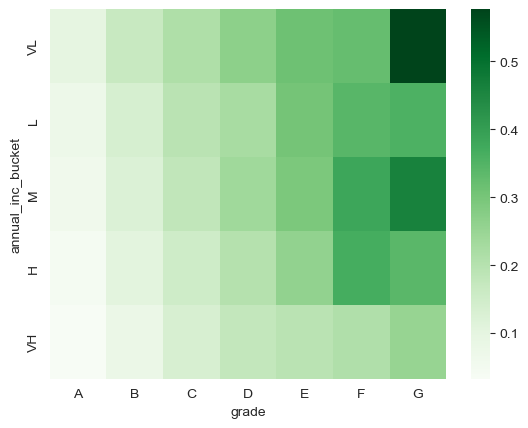

grade,A,B,C,D,E,F,G
annual_inc_bucket,,,,,,,
VL,0.098160,0.168115,0.211643,0.267081,0.313187,0.323232,0.576923
L,0.072737,0.134935,0.193438,0.225108,0.303704,0.342593,0.357143
M,0.060883,0.122947,0.180229,0.237325,0.292089,0.382857,0.461538
H,0.043410,0.107060,0.151860,0.201271,0.258929,0.367021,0.339286
VH,0.032752,0.080851,0.133333,0.176534,0.193227,0.211009,0.253333


In [121]:
plotHeatMapNumericCategorical('annual_inc', 'grade')

NO TRENDS TO OBSERVE

## Annual_Inc vs Purpose

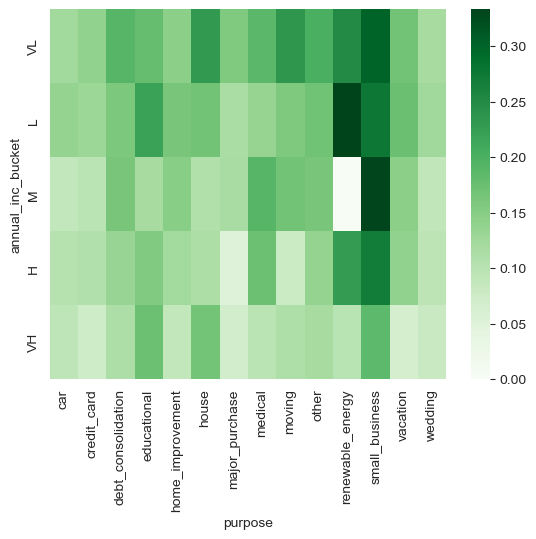

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
annual_inc_bucket,,,,,,,,,,,,,,
VL,0.124277,0.139771,0.190316,0.177778,0.145773,0.229508,0.155819,0.187097,0.234637,0.201566,0.250000,0.300676,0.168539,0.119205
L,0.137584,0.129989,0.159894,0.220000,0.162162,0.169231,0.115196,0.134921,0.157407,0.169275,0.333333,0.275000,0.175000,0.125000
M,0.087912,0.096643,0.162639,0.119048,0.148230,0.107143,0.117962,0.190476,0.168421,0.161473,0.000000,0.331190,0.144928,0.090909
H,0.101961,0.106736,0.133217,0.153846,0.123134,0.112676,0.053073,0.173913,0.077922,0.136054,0.227273,0.269841,0.138462,0.095745
VH,0.092937,0.074215,0.110790,0.173913,0.088624,0.166667,0.067935,0.097345,0.109756,0.119237,0.100000,0.185676,0.065574,0.082840


In [122]:
plotHeatMapNumericCategorical('annual_inc', 'purpose')

For renewable energy when income < 36000 dollars, there are a fair percentage of values that have defaulted.
For small business when income < 49000 dollars, there are a fair percentage of people that have defaulted.

## Annual_Inc vs Revol_Util

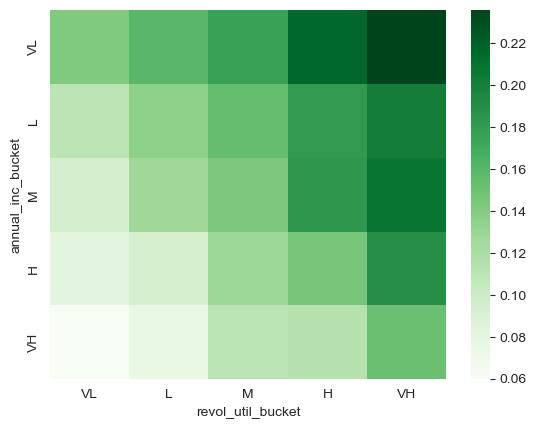

revol_util_bucket,VL,L,M,H,VH
annual_inc_bucket,,,,,
VL,0.141774,0.159292,0.176259,0.216092,0.236039
L,0.110023,0.136006,0.153574,0.181492,0.201631
M,0.094367,0.126653,0.143342,0.184193,0.208068
H,0.082966,0.093886,0.128369,0.146916,0.189452
VH,0.059680,0.076577,0.110874,0.114583,0.152672


In [123]:
plotHeatMap('annual_inc', 'revol_util')

This plot clearly shows that people with low income and high credit utilization have a default rate and people with high income and low credit utilization have a low default rate. These 2 variables are inversely proportional.

## Annual_Inc vs Home_Ownership

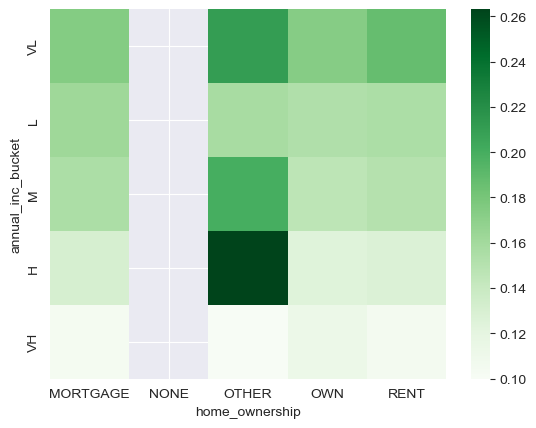

home_ownership,MORTGAGE,NONE,OTHER,OWN,RENT
annual_inc_bucket,,,,,
VL,0.174501,NaN,0.210526,0.173459,0.187111
L,0.162283,NaN,0.157895,0.153043,0.155079
M,0.154884,NaN,0.200000,0.146293,0.150403
H,0.131018,NaN,0.263158,0.124390,0.126909
VH,0.104021,NaN,0.100000,0.112392,0.104491


In [124]:
plotHeatMapNumericCategorical('annual_inc', 'home_ownership')

NO TRENDS TO OBSERVE

## Annual_Inc vs DTI

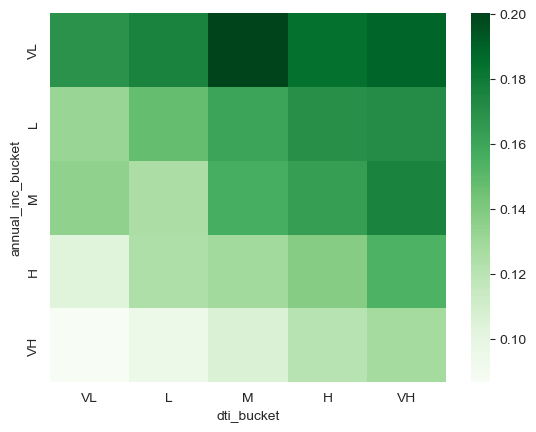

dti_bucket,VL,L,M,H,VH
annual_inc_bucket,,,,,
VL,0.168299,0.175210,0.200296,0.184173,0.188319
L,0.131474,0.147593,0.160428,0.169680,0.171182
M,0.134858,0.125273,0.156033,0.163201,0.175145
H,0.103039,0.124152,0.128753,0.137955,0.153666
VH,0.086503,0.095238,0.105435,0.121024,0.127551


In [125]:
plotHeatMap('annual_inc', 'dti')

There is a weak trend here, which is that a low income with high debt-to-income ratio reflects financial instability and can lead to defaults, but the rate of defaults does not vary a lot across the pivot table. Hence, this is a weak trend

## Revol_Util vs purpose

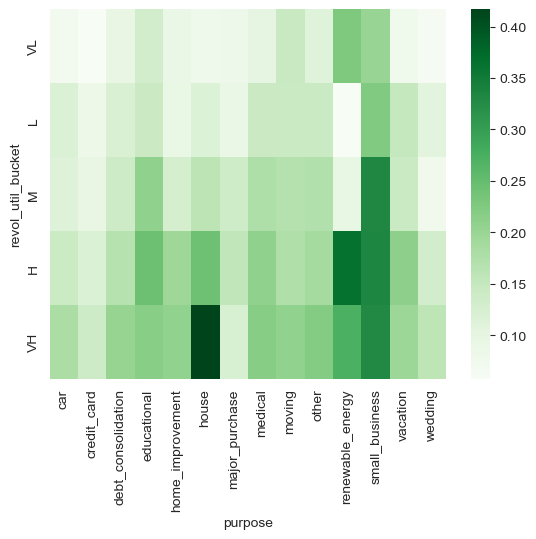

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
revol_util_bucket,,,,,,,,,,,,,,
VL,0.069903,0.057692,0.096918,0.132743,0.090408,0.080000,0.081633,0.101852,0.146497,0.111340,0.227273,0.201581,0.077586,0.064378
L,0.116618,0.083825,0.122149,0.142857,0.093870,0.115942,0.090069,0.142857,0.144231,0.143639,0.058824,0.223368,0.149254,0.106061
M,0.115044,0.095960,0.140177,0.210526,0.128641,0.161290,0.136943,0.175824,0.169014,0.172358,0.095238,0.332103,0.145161,0.076923
H,0.141463,0.119068,0.167225,0.243243,0.195652,0.242424,0.156379,0.210526,0.175258,0.187809,0.363636,0.334842,0.211538,0.133333
VH,0.180000,0.140234,0.202128,0.217391,0.207612,0.416667,0.123404,0.218487,0.209091,0.220506,0.272727,0.329317,0.196970,0.158730


In [126]:
plotHeatMapNumericCategorical('revol_util', 'purpose')

People with housing loans with a high credit utilization have a very high default ratio.

## Purpose vs Term

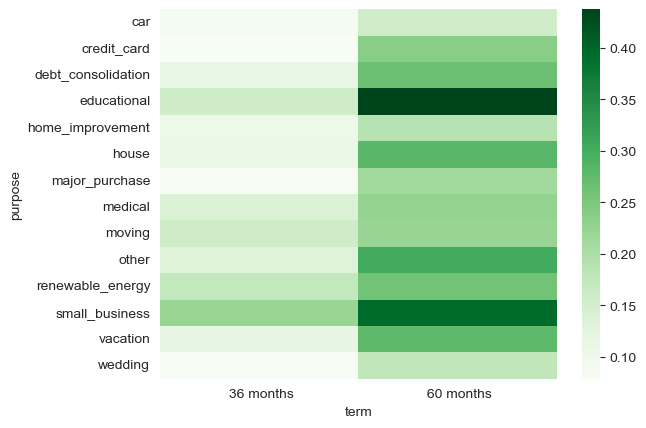

term,36 months,60 months
purpose,,
car,0.086772,0.155242
credit_card,0.078851,0.237695
debt_consolidation,0.113020,0.264871
educational,0.158784,0.437500
home_improvement,0.104715,0.187994
house,0.110169,0.280899
major_purchase,0.081395,0.213158
medical,0.139959,0.225352
moving,0.156522,0.222222


In [127]:
plotHeatMapCategorical('purpose', 'term')

Educational and Small business loans have a very high default ratio when the term given to fulfill the loan is 60 months.

## Revol_Util vs DTI

In [128]:
np.percentile(df['dti'], [0,20,40,60,80,100])

array([ 0.  ,  7.12, 11.58, 15.5 , 19.85, 29.99])

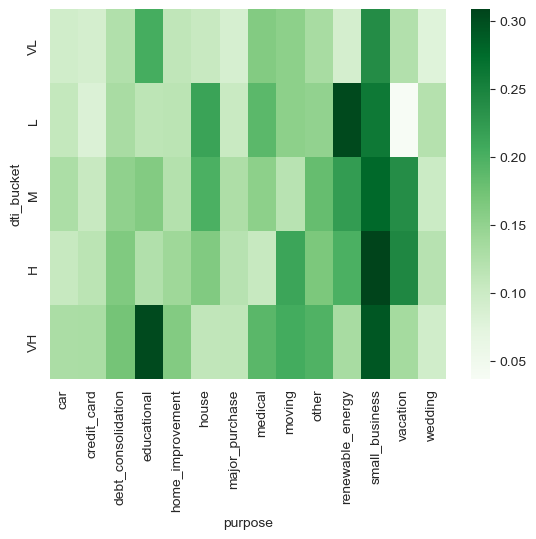

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
dti_bucket,,,,,,,,,,,,,,
VL,0.095238,0.090150,0.124361,0.204301,0.111860,0.104762,0.088456,0.161850,0.154321,0.133472,0.090909,0.238776,0.123711,0.078341
L,0.108025,0.081911,0.132298,0.114286,0.116022,0.214286,0.103753,0.189655,0.153846,0.150281,0.304348,0.260870,0.037037,0.120879
M,0.129278,0.104251,0.152581,0.161765,0.122449,0.200000,0.127660,0.154472,0.118280,0.181684,0.222222,0.277108,0.238095,0.100000
H,0.105000,0.115827,0.163823,0.125000,0.140665,0.163265,0.119565,0.105691,0.212121,0.167169,0.200000,0.308642,0.244898,0.119205
VH,0.130208,0.131332,0.172038,0.303030,0.161765,0.111111,0.111570,0.190000,0.204819,0.196541,0.133333,0.292453,0.135135,0.095238


In [129]:
plotHeatMapNumericCategorical('dti', 'purpose')

For education loans, a high dti can cause a higher default ratio

## DTI vs Term

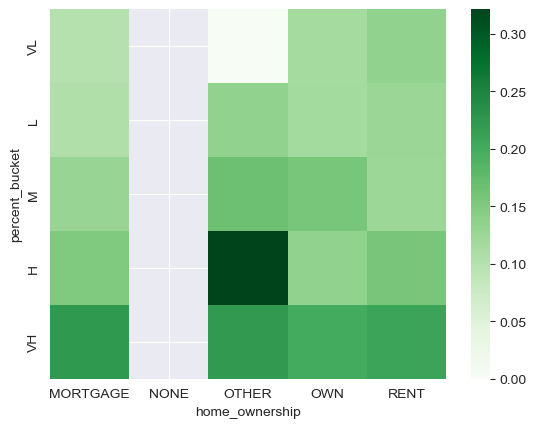

home_ownership,MORTGAGE,NONE,OTHER,OWN,RENT
percent_bucket,,,,,
VL,0.100058,NaN,0.000000,0.115702,0.134585
L,0.105296,NaN,0.133333,0.118110,0.126325
M,0.128684,NaN,0.166667,0.158103,0.124786
H,0.150391,NaN,0.321429,0.133574,0.156389
VH,0.222686,NaN,0.222222,0.199728,0.209560


In [130]:
plotHeatMapNumericCategorical('percent', 'home_ownership')

NO TRENDS TO OBSERVE